In [1]:
'''import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
 
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1-lri-HK_aq_UhHnprQTi5zg5sqldKVhm'  #雲端硬碟檔案連結碼
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('yahoo_total_data.csv')
data = pd.read_csv('yahoo_total_data.csv')
print(data)'''

"import pandas as pd\nfrom pydrive.auth import GoogleAuth\nfrom pydrive.drive import GoogleDrive \nfrom google.colab import auth \nfrom oauth2client.client import GoogleCredentials\n \nauth.authenticate_user()\ngauth = GoogleAuth()\ngauth.credentials = GoogleCredentials.get_application_default()\ndrive = GoogleDrive(gauth)\nfile_id = '1-lri-HK_aq_UhHnprQTi5zg5sqldKVhm'  #雲端硬碟檔案連結碼\ndownloaded = drive.CreateFile({'id': file_id})\ndownloaded.GetContentFile('yahoo_total_data.csv')\ndata = pd.read_csv('yahoo_total_data.csv')\nprint(data)"

In [2]:
import os
import time
import pandas as pd
import numpy as np
import time
from datetime import datetime
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
print(tf.__version__)

2.0.0


In [4]:
df = pd.read_csv('/PAPER/SRCNN/yahoo/yahoo_total_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572966 entries, 0 to 572965
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  572966 non-null  int64  
 1   timestamp   572966 non-null  int64  
 2   value       572966 non-null  float64
 3   is_anomaly  572966 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 17.5 MB


## Generate train data (有Label)

In [5]:
def average_filter(values, n=3):
    """
    Calculate the sliding window average for the give time series.
    Mathematically, res[i] = sum_{j=i-t+1}^{i} values[j] / t, where t = min(n, i+1)
    :param values: list.
        a list of float numbers
    :param n: int, default 3.
        window size.
    :return res: list.
        a list of value after the average_filter process.
    """

    if n >= len(values):
        n = len(values)

    res = np.cumsum(values, dtype=float)
    res[n:] = res[n:] - res[:-n]
    res[n:] = res[n:] / n

    for i in range(1, n):
        res[i] /= (i + 1)

    return res

In [6]:
class gen():
    def __init__(self, win_siz, step, nums):
        self.control = 0
        self.win_siz = win_siz
        self.step = step
        self.number = nums

    def generate_train_data(self, value, label, train_op, back_k=0):
        def normalize(a):
            amin = np.min(a)
            amax = np.max(a)
            a = (a - amin) / (amax - amin + 1e-5)
            return 3 * a

        if back_k <= 5:
            back = back_k
        else:
            back = 5
        length = len(value)
        tmp = []
        for pt in range(self.win_siz, length - back, self.step): # window=128 step=64 跳一次
            
            head = max(0, pt - self.win_siz)
            tail = min(length - back, pt)
            data = normalize(np.array(value[head:tail]).astype(np.float64)) # 以 window=128 做切割 (128,1)
            #lbs = np.array(label[head:tail]).astype(np.float64)    #有 label
            lbs = np.zeros(self.win_siz, dtype=np.int64)

            num = np.random.randint(1, self.number)   # [1, number] 之間隨機選一個整數 num
            ids = np.random.choice(self.win_siz, num, replace=False)  # 再從 window 之中選 num 個數 為異常
            
            if train_op:
                if (self.win_siz - 6) not in ids:    # control 累積到 100 若沒有 (window - 6) 在選擇內 則加進去 
                    self.control += np.random.random()  # [0,1] 之間隨機數
                else:
                    self.control = 0
                if self.control > 100:
                    ids[0] = self.win_siz - 6
                    self.control = 0

                mean = np.mean(data)
                dataavg = average_filter(data)
                var = np.var(data)

                for id in ids: # 將原始data加上異常以覆蓋  np.random.standard_cauchy / np.random.randn() / np.random.standard_t(10)
                    data[id] += (dataavg[id] + mean) * np.random.randn() * min((1 + var), 10)   # 製造異常 (保有Label 異常為1)
                    lbs[id] = 1
            
            tmp.append([data.tolist(), lbs.tolist()])
            
        return tmp

## Not One class data (自己加上異常並標全新Label)

In [7]:
window = 64
step = 32
num = 5  # upper limit value for the number of anomaly points

if __name__ == '__main__':

    results = []
    print("generating train data")
    generator = gen(window, step, num)
    
    in_timestamp, in_value, in_label = df['timestamp'], df['value'], df['is_anomaly']

    if len(in_value) < window:
        print("value's length < window size", len(in_value), window)
    
    half_len = int(len(in_value)/2)
    gen_data = generator.generate_train_data(in_value[:half_len], in_label[:half_len], True)  # [in_label==0] 丟原始異常
    X_train = np.array(gen_data).astype('float32')
    
    print('total fake data size:', len(gen_data))
    print('gen_data shape', np.array(gen_data).shape)
    print('train shape:', np.array(X_train).shape)
    

generating train data
total fake data size: 8951
gen_data shape (8951, 2, 64)
train shape: (8951, 2, 64)


In [8]:
print(sum(in_label==1))
print('異常點比例：', sum(in_label==1)/in_value.shape[0])

3915
異常點比例： 0.006832866173560037


## 未轉SR的Time Series與Label標記情況(前100筆window)

In [9]:
'''for i in range(100):
    print('picture  ', i)
    plt.plot(X_train[:,0][i])
    index_changes = np.where(X_train[:,1][i] == 1)
    plt.scatter(index_changes, X_train[:,0][i][index_changes], c='red', label="change point")
    plt.show()'''

'for i in range(100):\n    print(\'picture  \', i)\n    plt.plot(X_train[:,0][i])\n    index_changes = np.where(X_train[:,1][i] == 1)\n    plt.scatter(index_changes, X_train[:,0][i][index_changes], c=\'red\', label="change point")\n    plt.show()'

## 計算Spectral Residual

In [10]:
def spectral_residual(values):
    """
    This method transform a time series into spectral residual series
    :param values: list.
        a list of float values.
    :return: mag: list.
        a list of float values as the spectral residual values
    """
    EPS = 1e-8
    trans = np.fft.fft(values) #傅立葉變換
    mag = np.sqrt(trans.real ** 2 + trans.imag ** 2) #A(f)

    maglog = [np.log(item) if abs(item) > EPS else 0 for item in mag]  #L(f)

    spectral = np.exp(maglog - average_filter(maglog, n=3)) #R(f)

    trans.real = [ireal * ispectral / imag if abs(imag) > EPS else 0
                  for ireal, ispectral, imag in zip(trans.real, spectral, mag)]
    trans.imag = [iimag * ispectral / imag if abs(imag) > EPS else 0
                  for iimag, ispectral, imag in zip(trans.imag, spectral, mag)]

    wave_r = np.fft.ifft(trans)
    mag = np.sqrt(wave_r.real ** 2 + wave_r.imag ** 2) #S(x)

    return mag, maglog

In [11]:
class gen_set():
    def __init__(self, width, train_data):

        self.len = 0
        self.width = width
        self.train_data = train_data
        self.negrawlen = len(self.train_data)
        print('length :', len(self.train_data))
        
        self.len += self.negrawlen
        self.kpineglen = 0
        self.control = 0.

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        
        idx = index % self.negrawlen
        datas = np.array(self.train_data[idx])  # (2,128)
        data = datas[0, :].astype(np.float32)
        lbs = datas[1, :].astype(np.float32)
        
        wave, maglog = spectral_residual(data)
        waveavg = average_filter(wave)
        
        for i in range(self.width):   # 調整 Label的設置 #
            if wave[i] < 0.001 and waveavg[i] < 0.001:
                lbs[i] = 0
                continue
            ratio = wave[i] / waveavg[i]
            if ratio < 1.0 and lbs[i] == 1:
                lbs[i] = 0
            if ratio > 5.0:
                lbs[i] = 1
                
        srscore = abs(wave - waveavg) / (waveavg + 0.01)
        sortid = np.argsort(srscore)
        for idx in sortid[-2:]:
            if srscore[idx] > 5:
                lbs[idx] = 1
                
        resdata = 100 * np.array(wave)
        reslb = lbs
        
        return resdata, reslb, maglog

In [12]:
batch_size = 256
gen_data = gen_set(window, X_train)
data_list = []

for i in range(len(X_train)):
    data_list.append(gen_data.__getitem__(i))
    
train_x, train_y = np.array(data_list)[:,0], np.array(data_list)[:,1]

train_x = train_x.astype(np.float32)
train_y = train_y.astype(np.float32)

print('train_x shape', train_x.shape)
print('train_y.shape', train_y.shape)

train_buf = len(train_x)
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)) # change_label(train_y)
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)

length : 8951
train_x shape (8951, 64)
train_y.shape (8951, 64)


## log(A(f)) -- 前100筆window

In [13]:
'''for i in range(100):
    print('picture  ', i)
    plt.plot(np.array(data_list)[:,2][i])
    index_changes = np.where(train_y[i] == 1)
    plt.scatter(index_changes, np.array(data_list)[:,2][i][index_changes], c='red', label="change point")
    plt.legend()
    plt.show()'''

'for i in range(100):\n    print(\'picture  \', i)\n    plt.plot(np.array(data_list)[:,2][i])\n    index_changes = np.where(train_y[i] == 1)\n    plt.scatter(index_changes, np.array(data_list)[:,2][i][index_changes], c=\'red\', label="change point")\n    plt.legend()\n    plt.show()'

## 轉SR的Time Series與Label標記情況(前100筆window)

In [14]:
'''for i in range(100):
    print('picture  ', i)
    plt.plot(train_x[i])
    index_changes = np.where(train_y[i] == 1)
    plt.scatter(index_changes, train_x[i][index_changes], c='red', label="change point")
    plt.legend()
    plt.show()'''

'for i in range(100):\n    print(\'picture  \', i)\n    plt.plot(train_x[i])\n    index_changes = np.where(train_y[i] == 1)\n    plt.scatter(index_changes, train_x[i][index_changes], c=\'red\', label="change point")\n    plt.legend()\n    plt.show()'

## 加入CNN做訓練

In [15]:
def make_anomaly_model():
    
    inputs = tf.keras.Input(shape=(window, 1))  

    x = layers.Conv1D(window, kernel_size=1, padding='valid', strides=1, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-4))(inputs)
    x = layers.ReLU()(x)
    x = layers.Conv1D(2 * window, kernel_size=1, padding='valid', strides=1, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-4))(x)
    x = layers.Flatten()(x)
    x = layers.ReLU()(x)
    x = layers.Dense(4 * window, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-4))(x)
    x = layers.ReLU()(x)
    x = layers.Dense(window, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-4))(x)  # sigmoid 在 loss 加上
    #x = tf.math.sigmoid(x)
    model = tf.keras.Model(inputs = inputs, outputs=x)
    
    return model
anomaly_model = make_anomaly_model()
anomaly_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 64, 64)            128       
_________________________________________________________________
re_lu (ReLU)                 (None, 64, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 128)           8320      
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
re_lu_1 (ReLU)               (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               209740

In [16]:
clr = 1e-6
optimizer = tf.keras.optimizers.Adam(lr = clr)   #Adam

def adjust_lr(epoch, lr):
    cur_lr = lr * (0.5 ** ((epoch + 10) // 10))
    return cur_lr

def calc(pred, true):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for pre, gt in zip(pred, true):
        if gt == 1:
            if pre == 1:
                TP += 1
            else:
                FN += 1
        if gt == 0:
            if pre == 1:
                FP += 1
            else:
                TN += 1
    return TP, FP, TN, FN

In [17]:
def weight_binary_crossentropy(y_true, y_pred):
    weight = 2.7853
    loss = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, pos_weight=weight)
    #loss = tf.nn.sigmoid_cross_entropy_with_logits(y_true, y_pred)   # 
    return loss

@tf.function
def train_model(batch_x, batch_y):
    with tf.GradientTape() as tape:
        predict = anomaly_model(batch_x, training=True)
        output_loss = weight_binary_crossentropy(batch_y, predict)
        
    grads = tape.gradient(output_loss, anomaly_model.trainable_variables)
    grads, _ = tf.clip_by_global_norm(grads, 5.0)
    optimizer.apply_gradients(zip(grads, anomaly_model.trainable_variables))

    return output_loss, predict

In [18]:
#anomaly_model.save('anomaly_model_weight.h5')

In [19]:
#anomaly_model.save_weights('anomaly_model_weight')

In [20]:
anomaly_model.load_weights('anomaly_model_weight')

   0: TIME: 2.60 LOSS: 0.879395 
 100: TIME: 0.23 LOSS: 0.167116 
 200: TIME: 0.25 LOSS: 0.131200 
 300: TIME: 0.26 LOSS: 0.119906 
 400: TIME: 0.28 LOSS: 0.114458 
 500: TIME: 0.26 LOSS: 0.111125 
 600: TIME: 0.27 LOSS: 0.108789 
 700: TIME: 0.25 LOSS: 0.106924 
 800: TIME: 0.25 LOSS: 0.105325 
 900: TIME: 0.33 LOSS: 0.103903 
1000: TIME: 0.30 LOSS: 0.102622 
1100: TIME: 0.28 LOSS: 0.101389 
1200: TIME: 0.28 LOSS: 0.100234 
1300: TIME: 0.22 LOSS: 0.099124 
1400: TIME: 0.32 LOSS: 0.098065 
1500: TIME: 0.22 LOSS: 0.097055 
1600: TIME: 0.34 LOSS: 0.096081 
1700: TIME: 0.36 LOSS: 0.095143 
1800: TIME: 0.28 LOSS: 0.094229 
1900: TIME: 0.34 LOSS: 0.093344 
2000: TIME: 0.28 LOSS: 0.092467 
2100: TIME: 0.30 LOSS: 0.091617 
2200: TIME: 0.28 LOSS: 0.090793 
2300: TIME: 0.28 LOSS: 0.089988 
2400: TIME: 0.34 LOSS: 0.089190 
2500: TIME: 0.37 LOSS: 0.088410 
2600: TIME: 0.26 LOSS: 0.087646 
2700: TIME: 0.27 LOSS: 0.086901 
2800: TIME: 0.27 LOSS: 0.086168 
2900: TIME: 0.28 LOSS: 0.085449 
3000: TIME

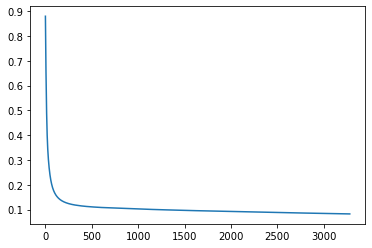

In [21]:
checkpoint_dir = './anomaly_model'
checkpoint = tf.train.Checkpoint(doptimizer = optimizer)

threshold = 0.5
n_epochs = 10000
start = 0
pre_loss = 0

loss_list = []
for epoch in range(n_epochs):
    start = time.time()

    epoch_loss_avg = tf.metrics.Mean()
    
    for batch_id, (batch) in enumerate(train_dataset):
        batch_x, batch_y = batch[0], batch[1]
        
        optimizer.lr = clr
        loss_, output = train_model(tf.expand_dims(batch_x, axis=2), batch_y)
        epoch_loss_avg(loss_)
        
    loss_list.append(epoch_loss_avg.result())
    
    if abs(pre_loss - epoch_loss_avg.result()) < 1e-8:
        break
    pre_loss = epoch_loss_avg.result()
    
    epoch_time = time.time() - start
    if epoch % 100 == 0:
        epoch_time = time.time() - start
        print('{:4d}: TIME: {:.2f} LOSS: {:.6f} '.format(epoch, epoch_time, epoch_loss_avg.result()))
    
    anomaly_model.save_weights('anomaly_model_weight_1')
        
checkpoint.save(file_prefix = checkpoint_dir)
plt.plot(loss_list)
plt.show()

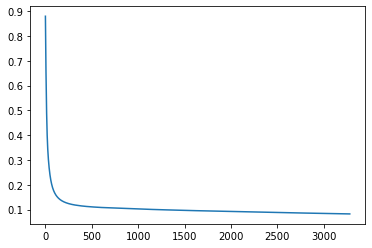

In [22]:
plt.plot(loss_list)
plt.show()

In [23]:
#anomaly_model.save('anomaly_model_yahoo_test3_n.h5')

## Evaluation

In [31]:
def predict_next(values):
    """
    Predicts the next value by sum up the slope of the last value with previous values.
    Mathematically, g = 1/m * sum_{i=1}^{m} g(x_n, x_{n-i}), x_{n+1} = x_{n-m+1} + g * m,
    where g(x_i,x_j) = (x_i - x_j) / (i - j)
    :param values: list.
        a list of float numbers.
    :return : float.
        the predicted next value.
    """

    if len(values) <= 1:
        raise ValueError(f'data should contain at least 2 numbers')
    
    v_last = values[-1]
    n = len(values)

    slopes = [(v_last - v) / (n - 1 - i) for i, v in enumerate(values[:-1])]

    return values[1] + sum(slopes)

def extend_series(values, extend_num=5, look_ahead=5):
    """
    extend the array data by the predicted next value
    :param values: list.
        a list of float numbers.
    :param extend_num: int, default 5.
        number of values added to the back of data.
    :param look_ahead: int, default 5.
        number of previous values used in prediction.
    :return: list.
        The result array.
    """

    if look_ahead < 1:
        raise ValueError('look_ahead must be at least 1')
    values = list(values)
    extension = [predict_next(values[-look_ahead - 2:-1])] * extend_num
    return values + extension

In [32]:
def get_range_proba(predict, label, delay=7):
    predict = np.array(predict)
    label = np.array(label)

    splits = np.where(label[1:] != label[:-1])[0] + 1
    is_anomaly = label[0] == 1
    new_predict = np.array(predict)
    pos = 0

    for sp in splits:
        if is_anomaly:
            if 1 in predict[pos:min(pos + delay + 1, sp)]:
                new_predict[pos: sp] = 1
            else:
                new_predict[pos: sp] = 0
        is_anomaly = not is_anomaly
        pos = sp
    sp = len(label)

    if is_anomaly:
        if 1 in predict[pos: min(pos + delay + 1, sp)]:
            new_predict[pos: sp] = 1
        else:
            new_predict[pos: sp] = 0

    return new_predict


def reconstruct_label(timestamp, label):
    
    timestamp = np.asarray(timestamp)
    index = np.argsort(timestamp)

    timestamp_sorted = np.asarray(timestamp[index])
    interval = np.min(np.diff(timestamp_sorted))

    label = np.asarray(label, np.int64)
    label = np.asarray(label[index])

    idx = (timestamp_sorted - timestamp_sorted[0]) // interval

    new_label = np.zeros(shape=((timestamp_sorted[-1] - timestamp_sorted[0]) // interval + 1,), dtype=np.int)
    new_label[idx] = label

    return new_label


def reconstruct_series(timestamp, label, predict, delay=7):
    
    label = reconstruct_label(timestamp, label)
    predict = reconstruct_label(timestamp, predict)
    predict = get_range_proba(predict, label, delay)  # 考慮延遲異常點
    return list(label), list(predict)

In [33]:
def evaluate_for_all_series(lst_timestamp_label_predict, delay=7, prt=True):
    labels, predicts = [], []
    for timestamp, label, predict in lst_timestamp_label_predict:
        if timestamp == []:
            continue
        lbl, pdt = reconstruct_series(timestamp, label, predict, delay)
        labels += lbl
        predicts += pdt

    f1 = f1_score(labels, predicts)
    pre = precision_score(labels, predicts)
    rec = recall_score(labels, predicts)
    TP, FP, TN, FN = calc(predicts, labels)
    auc = roc_auc_score(labels, predicts)
    if prt:
        print('precision', pre)
        print('recall', rec)
        print('f1', f1)
        print('TP: {:} FP: {:} TN: {:} FN: {:}'.format(TP, FP, TN, FN))
        print('AUC', auc)
        print('-------------------------------')
    return f1, pre, rec, TP, FP, TN, FN

In [34]:
def window_test(timestamp, value, in_label, back_k=0, backaddnum=5, step=32):

    win_size = window
    length = len(timestamp)
    if back_k <= 5:
        back = back_k
    else:
        back = 5
        
    v_list = []
    l_list = []
    mag_list = []
    for pt in range(int(win_size - backaddnum + back + step), int(length - back), step):
        head = max(0, pt - (win_size - backaddnum))
        tail = min(length, pt)
        wave = np.array(extend_series(value[head:tail + back])) # backaddnum = 增加K個估計點 K=5
        label = np.array(extend_series(in_label[head:tail + back]))
        mag, _ = spectral_residual(wave)
        
        v_list.append(wave)
        l_list.append(label)
        mag_list.append(mag)
    
    return mag_list, v_list, l_list

In [35]:
def sr_cnn_eval(SR_output, timestamp, value, label, ms_optioin, threshold=0.95, back_k=0, backaddnum=5, step=32):

    def modelwork(x):
        x = 100 * np.array(x)
        x = np.expand_dims(x, axis=2)
        
        #anomaly_model = tf.keras.models.load_model('anomaly_model_yahoo_test3_n.h5', compile=False)
        output = tf.math.sigmoid(anomaly_model(x, training=False))
        aa = np.reshape(output, [1, -1])
        res = np.where(aa > threshold, 1, 0)
        aa = np.reshape(aa, [-1, win_size])
        res = np.reshape(res, [-1, win_size])
        
        return res, aa

    win_size = window
    length = len(timestamp)
    if back_k <= 5:
        back = back_k
    else:
        back = 5
    detres = np.zeros((win_size - backaddnum,))
    scores = np.zeros((win_size - backaddnum,))

    modeloutput, rawout = modelwork(SR_output)
    num = 0
    for pt in range(int(win_size - backaddnum + back + step), int(length - back), step):
        head = max(0, pt - (win_size - backaddnum))
        tail = min(length, pt)
        modeloutput_ = modeloutput[num,:]
        rawout_ = rawout[num,:]
        num += 1
        
        for ipt in range(pt - step - back, pt - back):
            detres = np.append(detres, modeloutput_[ipt - head])
            scores = np.append(scores, rawout_[ipt - head].item())
    
    detres = np.append(detres, np.zeros((length - len(detres),)))   # detres : predict結果 [0,1]顯示
    scores = np.append(scores, np.zeros((length - len(scores),)))   # scores : predict結果 未切割[0,1]顯示
    
    if ms_optioin == 'anomaly':
        last = -1
        
        interval = min([timestamp[i] - timestamp[i - 1] for i in range(1, len(timestamp))]) # 計算兩兩間隔時間 取min
        for i in range(1, len(timestamp)):
            if timestamp[i] - timestamp[i - 1] > interval:
                if last >= 0 and i - last < 1000:
                    detres[i] = 1
                    scores[i] = 1
            if detres[i] == 1:
                last = i
    
    return list(timestamp), label[:], detres[:], scores[:], rawout

In [36]:
def get_score(thres, option):
    total_time = 0
    results = []
    savedscore = []
    
    df_test = pd.read_csv('yahoo_total_data.csv')
    half_len = int(df_test.shape[0]/2)
    in_timestamp, in_value, in_label = df_test['timestamp'][half_len:], df_test['value'][half_len:], df_test['is_anomaly'][half_len:]
    
    
    length = len(in_timestamp)
    
    time_start = time.time()
    SR_output, w_value, w_label = window_test(np.array(in_timestamp), in_value, in_label)
    #print(np.array(SR_output).shape)
    timestamp, label, pre, scores, cnnout = sr_cnn_eval(SR_output, np.array(in_timestamp), in_value, in_label, option, thres)
    
    time_end = time.time()
    total_time = time_end - time_start
    results.append([timestamp, label, pre])
    savedscore.append([label, scores, timestamp])
    
    return total_time, results, savedscore, SR_output, w_value, w_label, cnnout

In [37]:
thres = 0.06
missing_option = 'anomaly'
delay = 3
window = 64

total_time, results, savedscore, SR_output, test_value, test_label, cnnout = get_score(thres, missing_option)
total_fscore, pre, rec, TP, FP, TN, FN = evaluate_for_all_series(results, delay) # 只拿[0,1]結果

print('time used for making predictions:', total_time, 'seconds')
print('AUC', roc_auc_score(np.array(savedscore)[0][0], np.array(savedscore)[0][1]))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

precision 0.04684350822443274
recall 0.9743069641649763
f1 0.08938928693278744
TP: 1441 FP: 29321 TN: 255683 FN: 38
AUC 0.9357138531649992
-------------------------------
time used for making predictions: 207.70344638824463 seconds
AUC 0.9879125784590959


## plot normal / anomaly window

picture   0


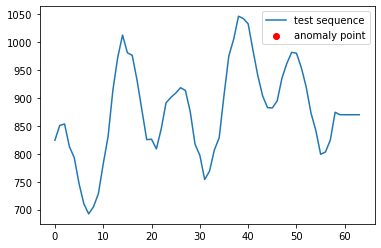

picture   1


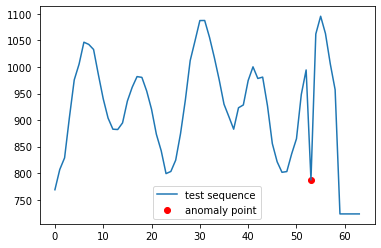

picture   2


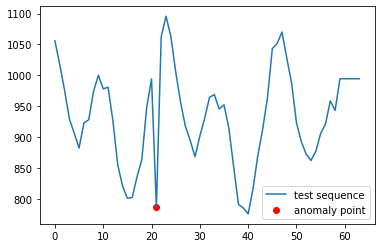

picture   3


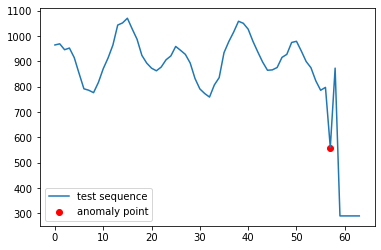

picture   4


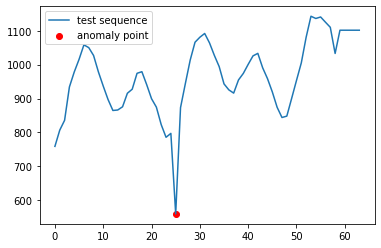

picture   5


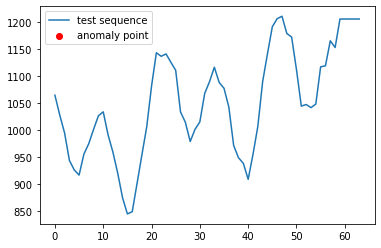

picture   6


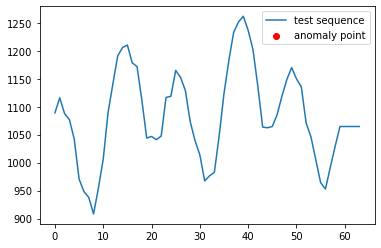

picture   7


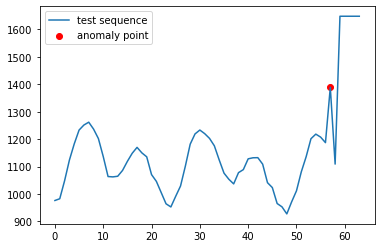

picture   8


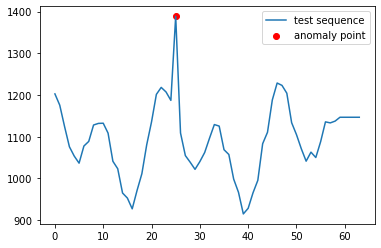

picture   9


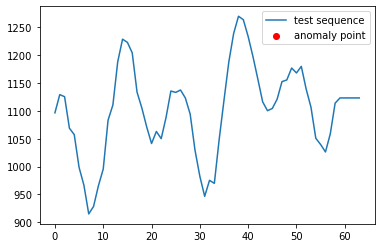

picture   10


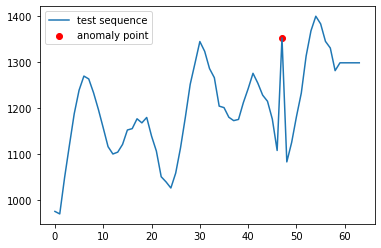

picture   11


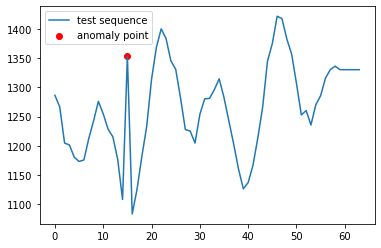

picture   12


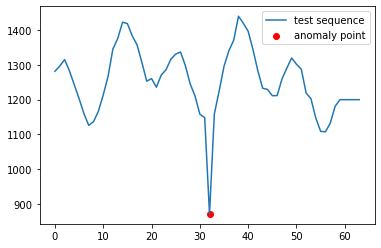

picture   13


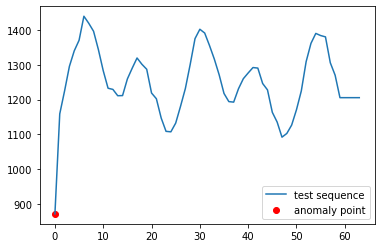

picture   14


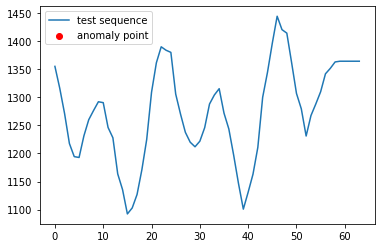

picture   15


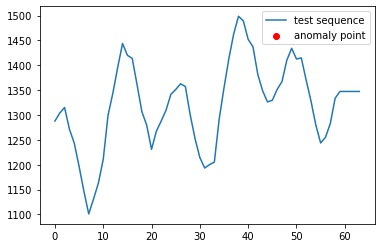

picture   16


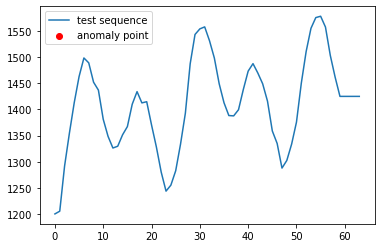

picture   17


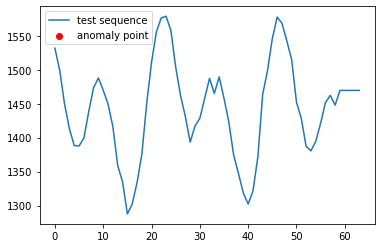

picture   18


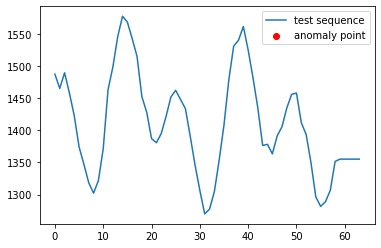

picture   19


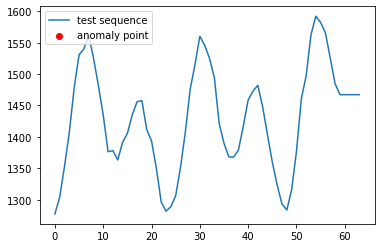

picture   20


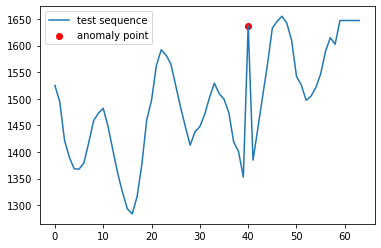

picture   21


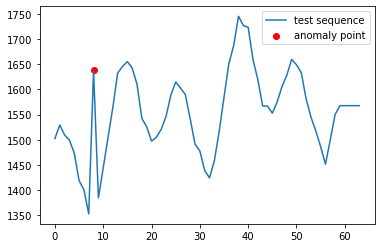

picture   22


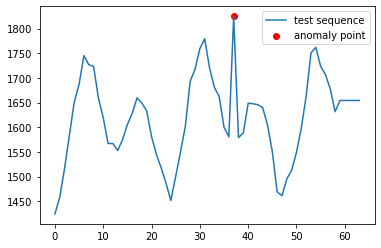

picture   23


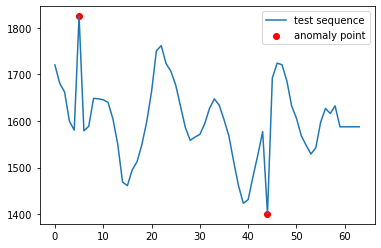

picture   24


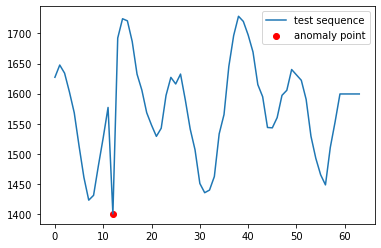

picture   25


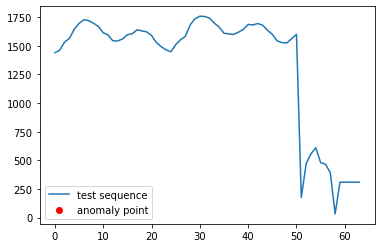

picture   26


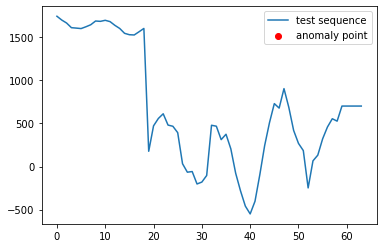

picture   27


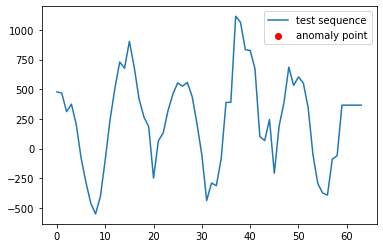

picture   28


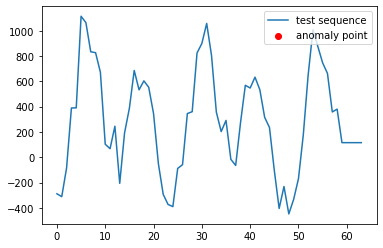

picture   29


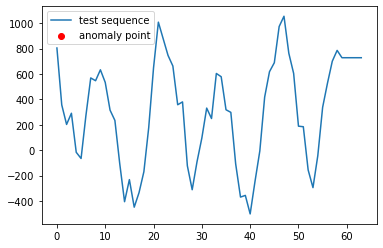

picture   30


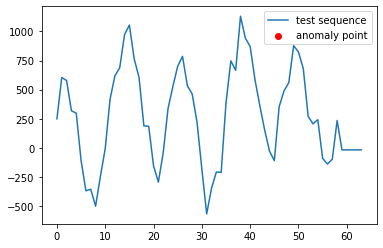

picture   31


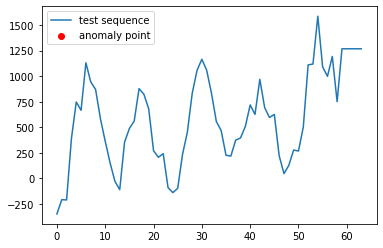

picture   32


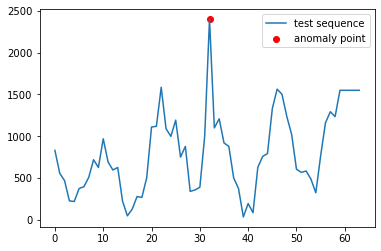

picture   33


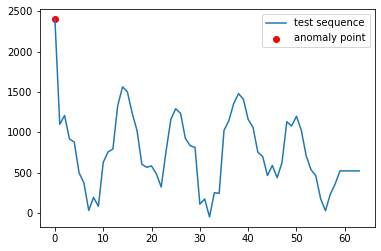

picture   34


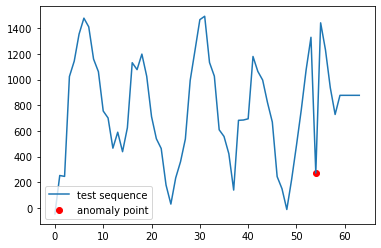

picture   35


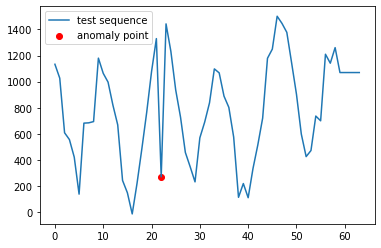

picture   36


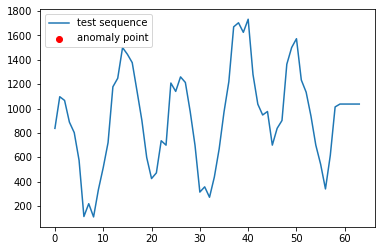

picture   37


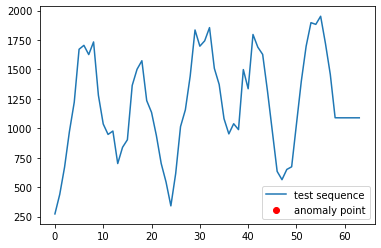

picture   38


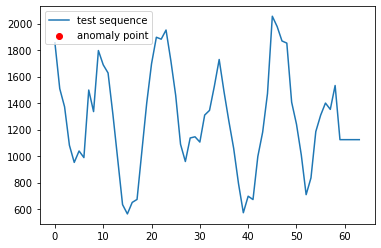

picture   39


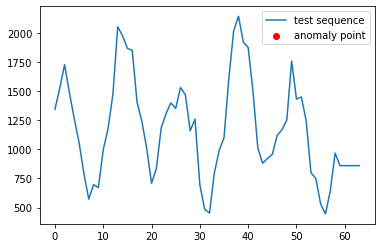

picture   40


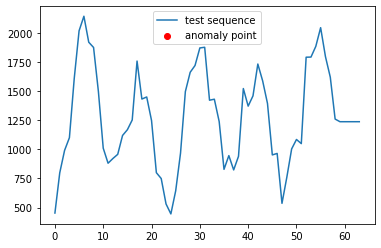

picture   41


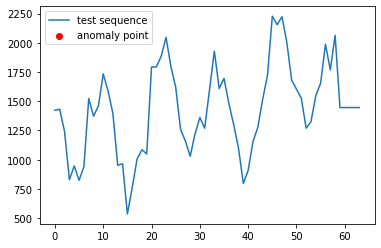

picture   42


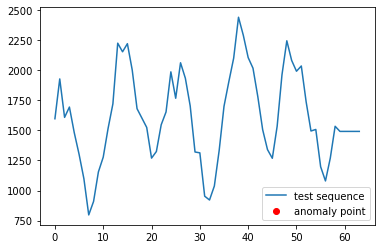

picture   43


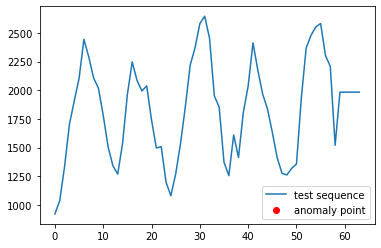

picture   44


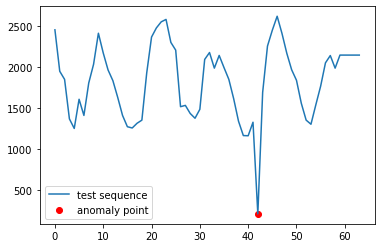

picture   45


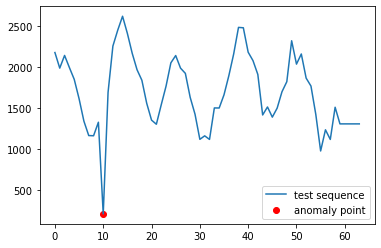

picture   46


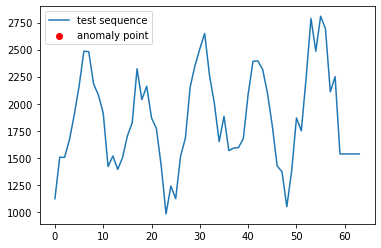

picture   47


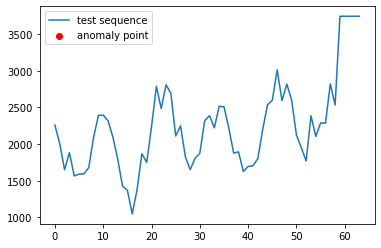

picture   48


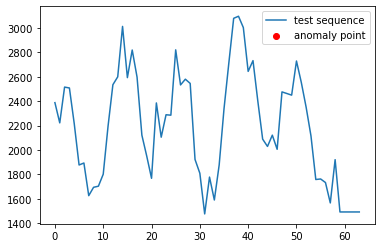

picture   49


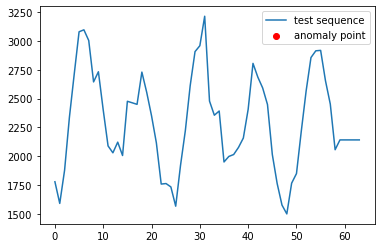

picture   50


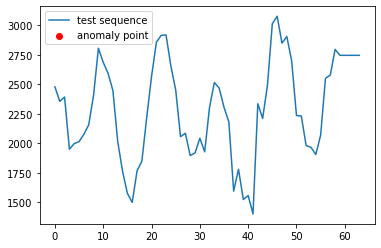

picture   51


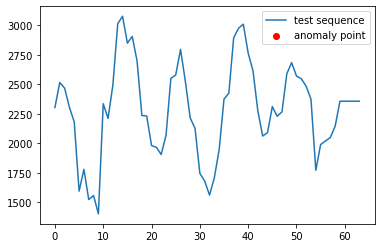

picture   52


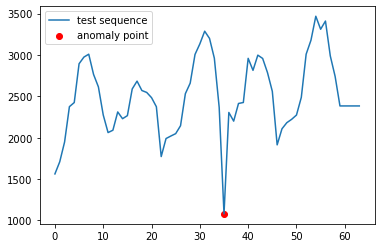

picture   53


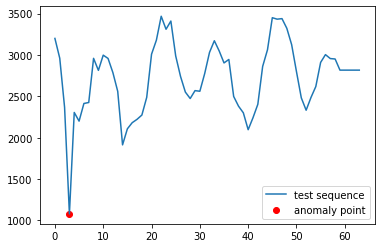

picture   54


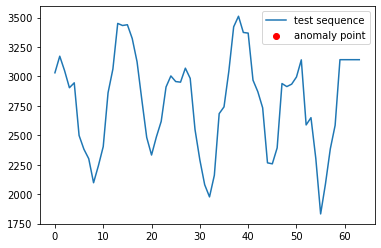

picture   55


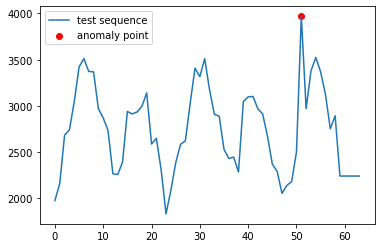

picture   56


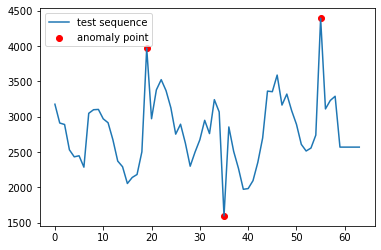

picture   57


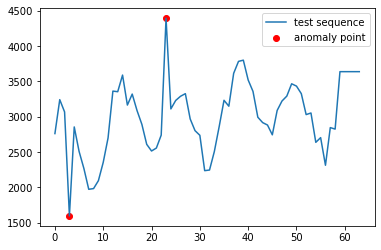

picture   58


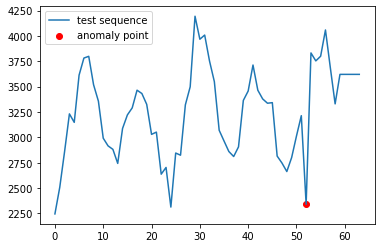

picture   59


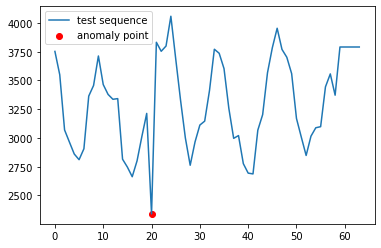

picture   60


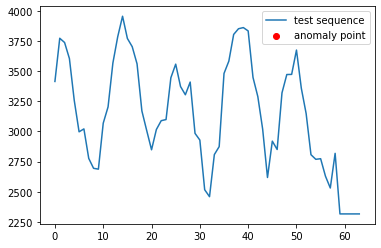

picture   61


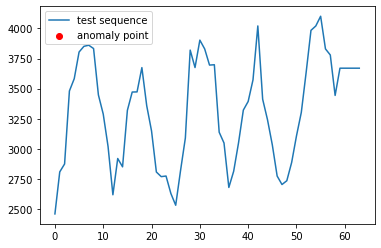

picture   62


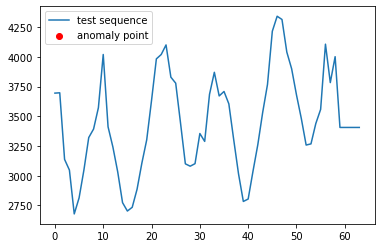

picture   63


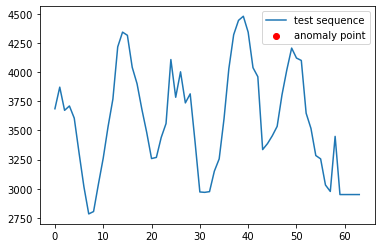

picture   64


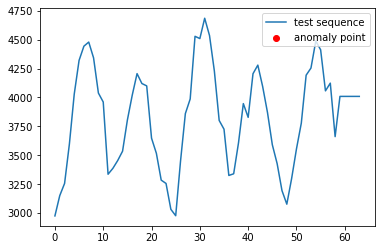

picture   65


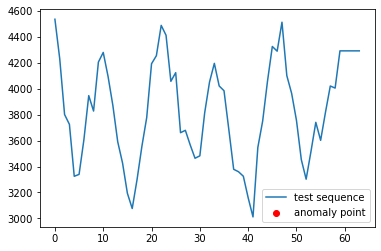

picture   66


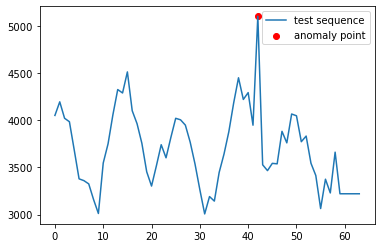

picture   67


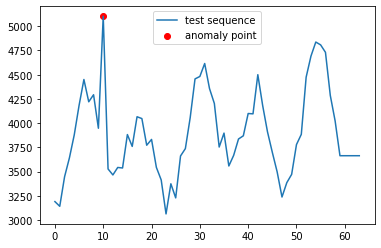

picture   68


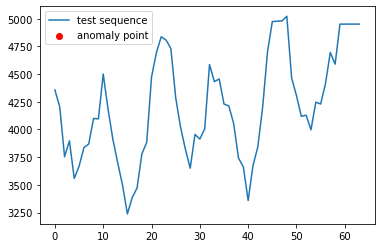

picture   69


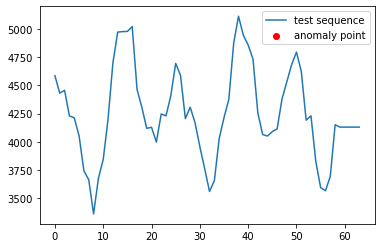

picture   70


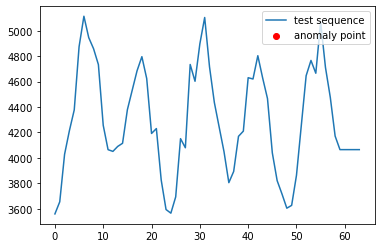

picture   71


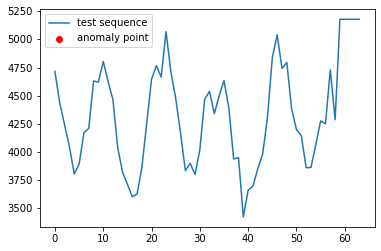

picture   72


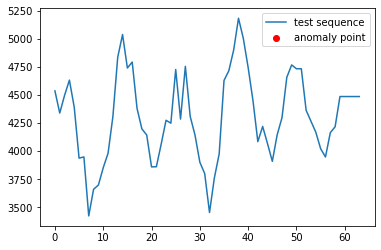

picture   73


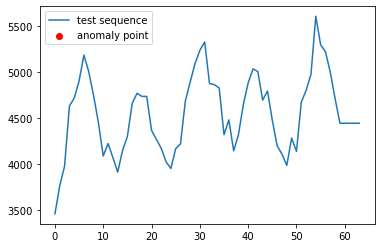

picture   74


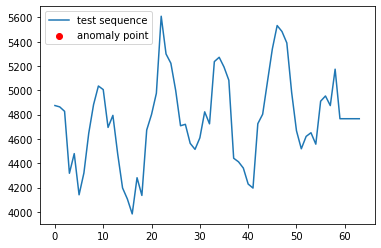

picture   75


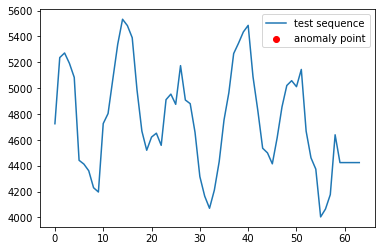

picture   76


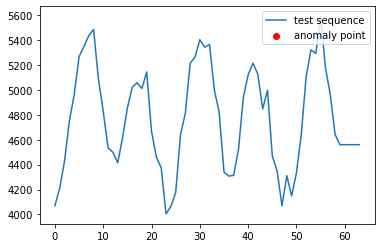

picture   77


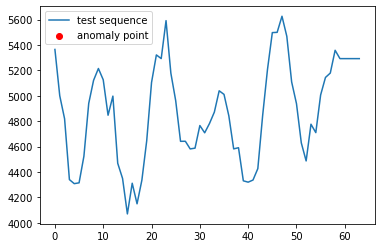

picture   78


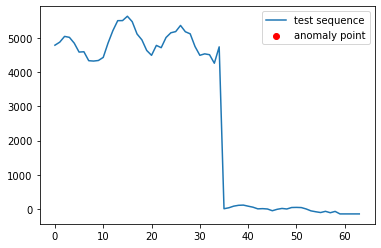

picture   79


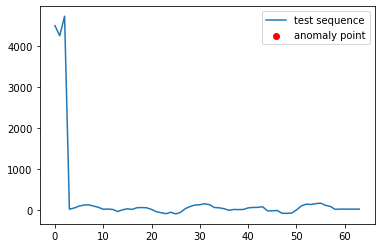

picture   80


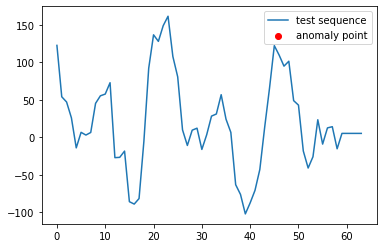

picture   81


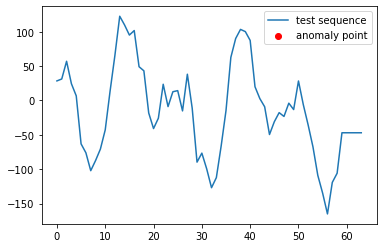

picture   82


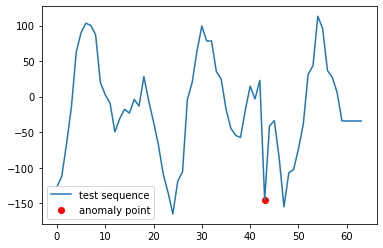

picture   83


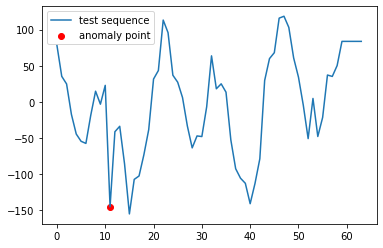

picture   84


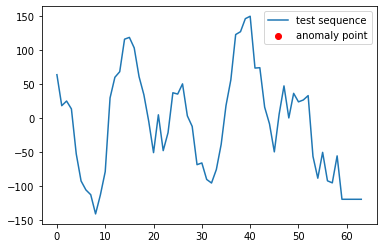

picture   85


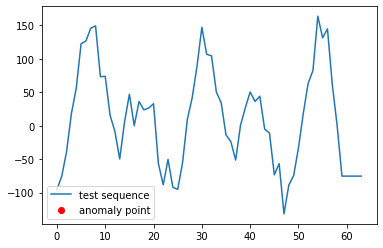

picture   86


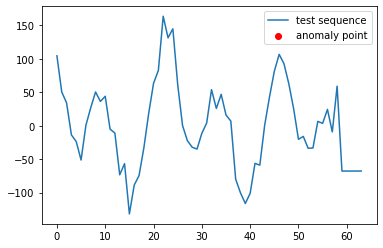

picture   87


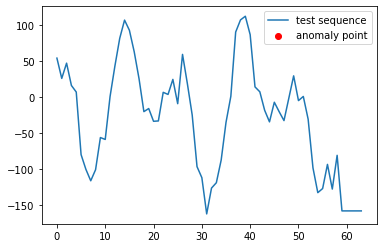

picture   88


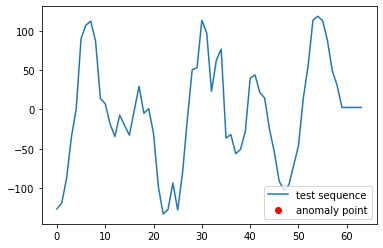

picture   89


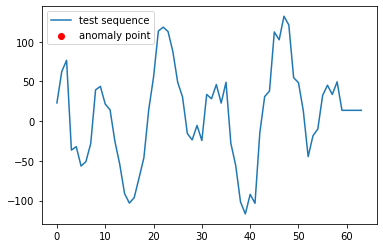

picture   90


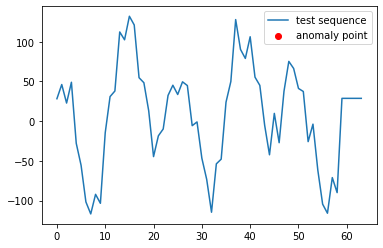

picture   91


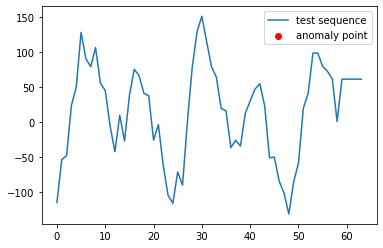

picture   92


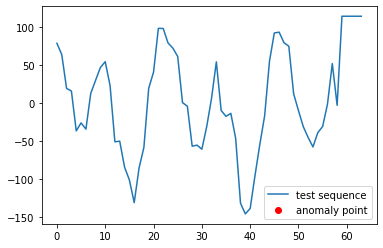

picture   93


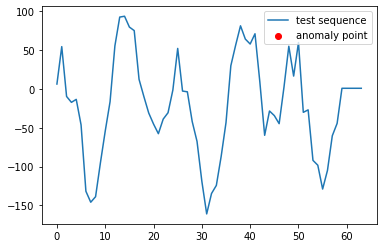

picture   94


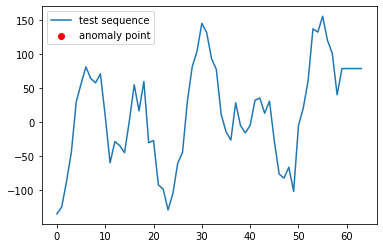

picture   95


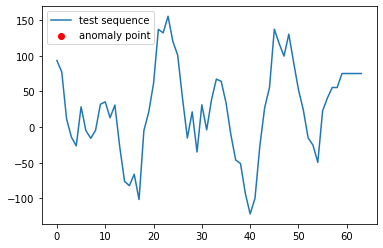

picture   96


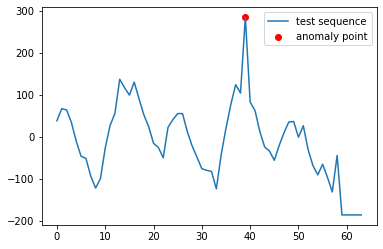

picture   97


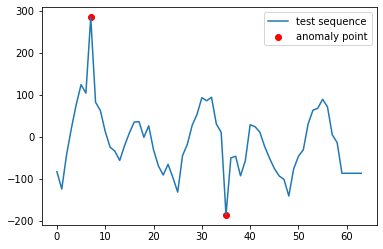

picture   98


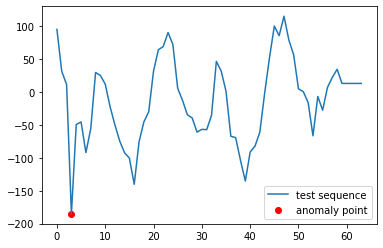

picture   99


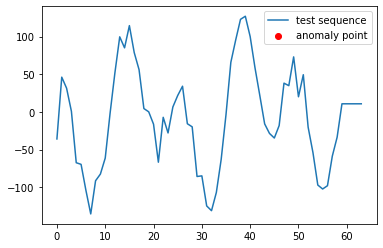

In [38]:
for i in range(100):
    print('picture  ', i)
    plt.plot(test_value[i], label='test sequence')
    index_changes = np.where(test_label[i] == 1)
    plt.scatter(index_changes, test_value[i][index_changes], c='red', label="anomaly point")
    plt.legend()
    plt.show()

picture   0


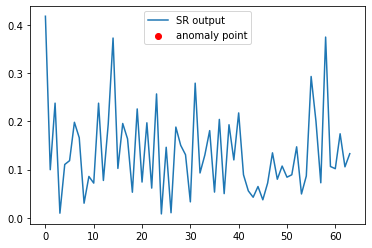

picture   1


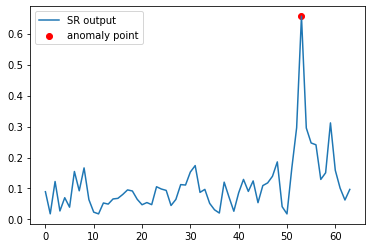

picture   2


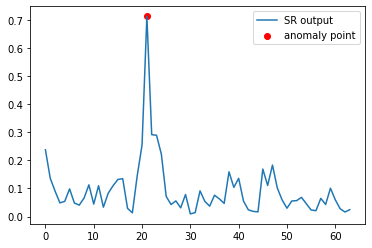

picture   3


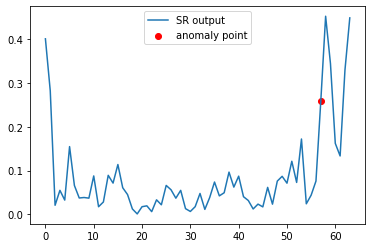

picture   4


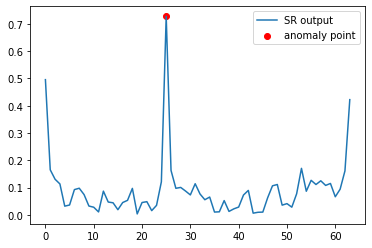

picture   5


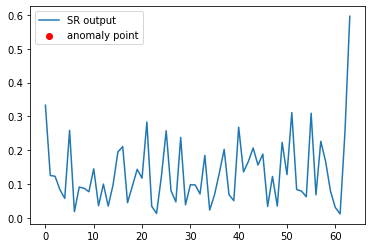

picture   6


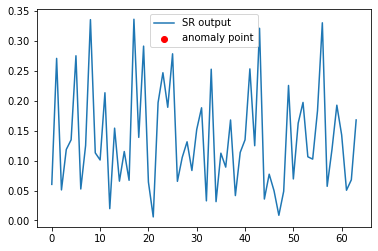

picture   7


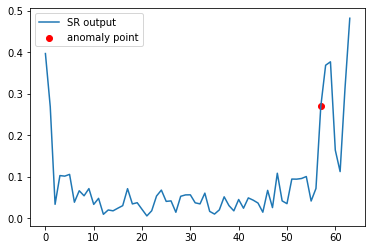

picture   8


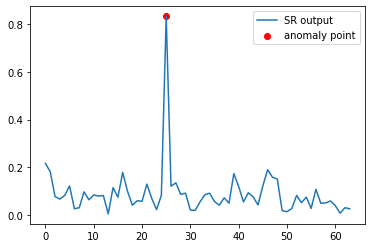

picture   9


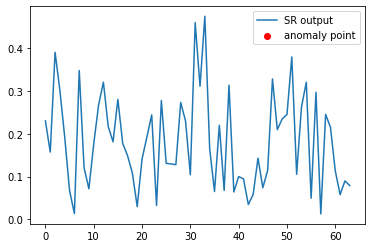

picture   10


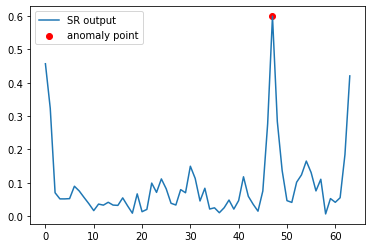

picture   11


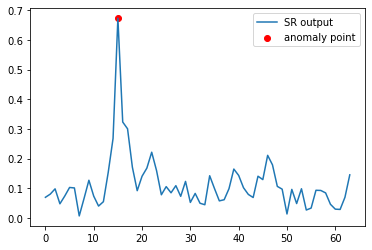

picture   12


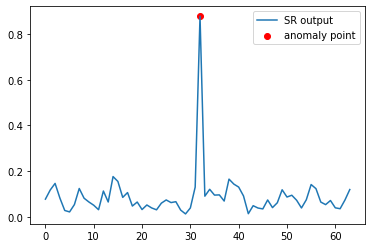

picture   13


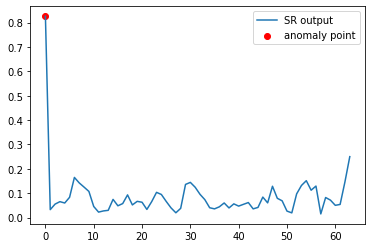

picture   14


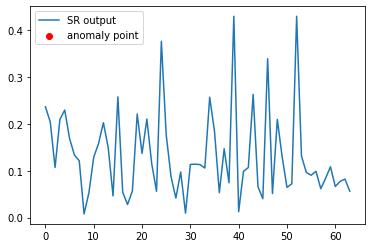

picture   15


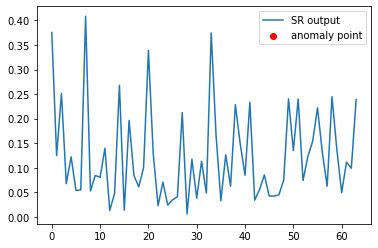

picture   16


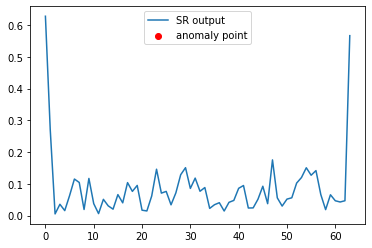

picture   17


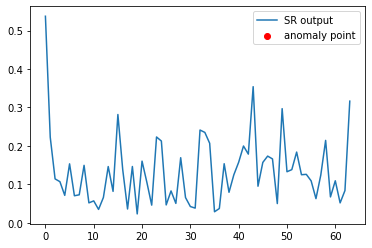

picture   18


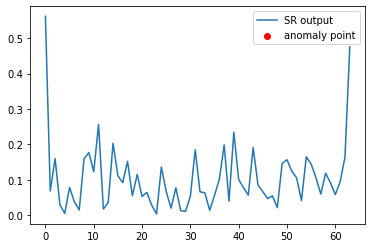

picture   19


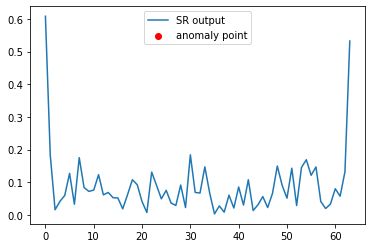

picture   20


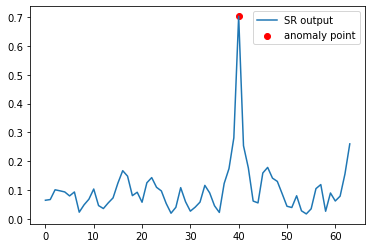

picture   21


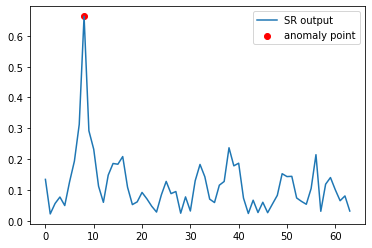

picture   22


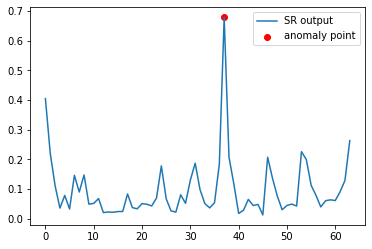

picture   23


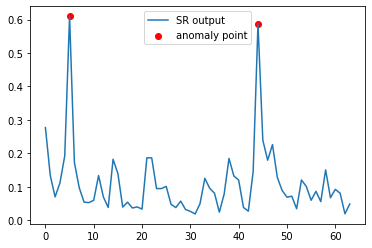

picture   24


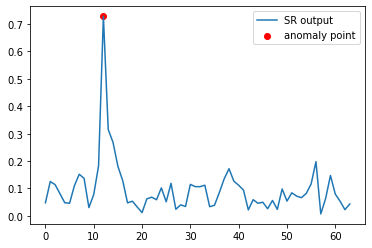

picture   25


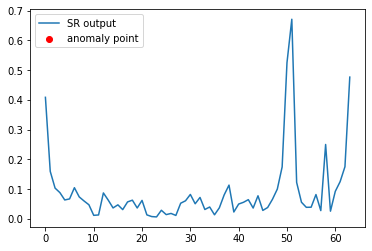

picture   26


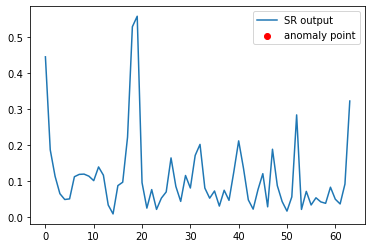

picture   27


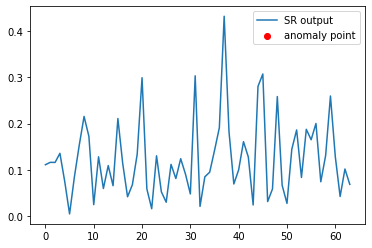

picture   28


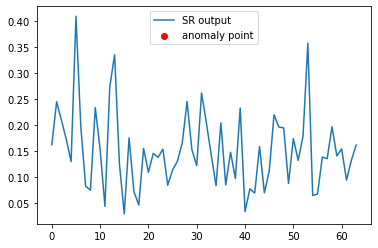

picture   29


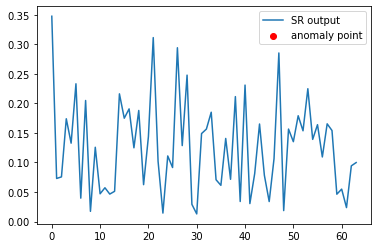

picture   30


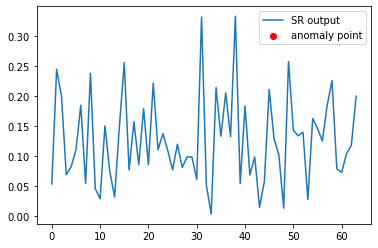

picture   31


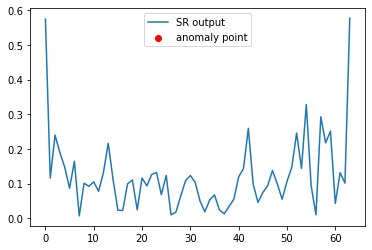

picture   32


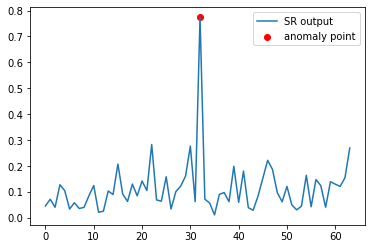

picture   33


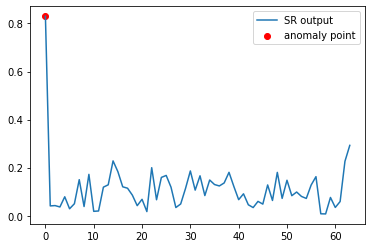

picture   34


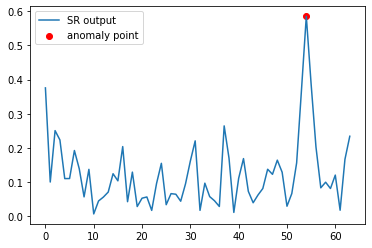

picture   35


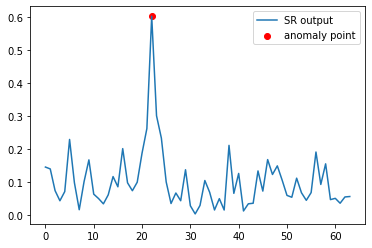

picture   36


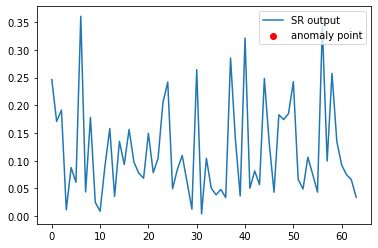

picture   37


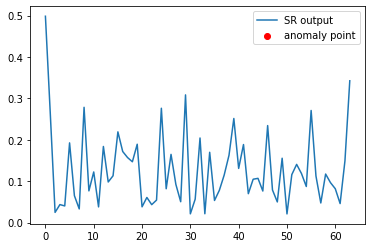

picture   38


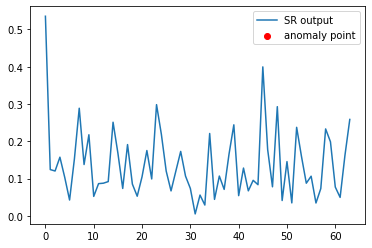

picture   39


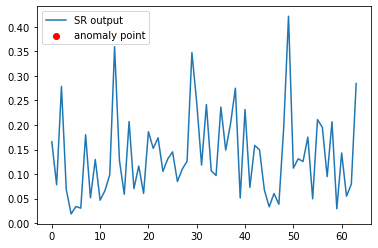

picture   40


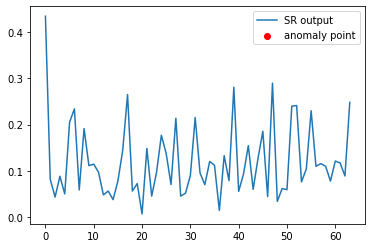

picture   41


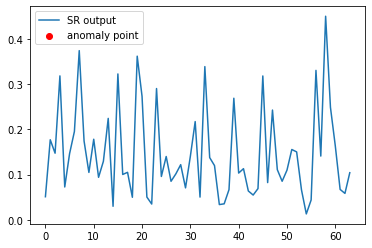

picture   42


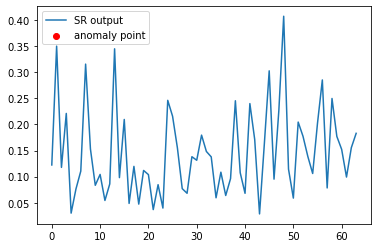

picture   43


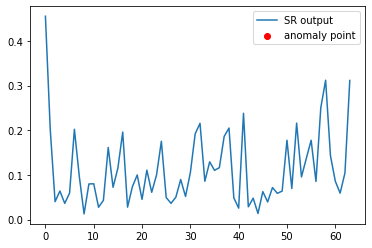

picture   44


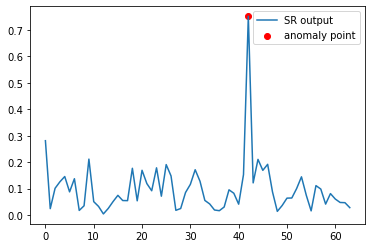

picture   45


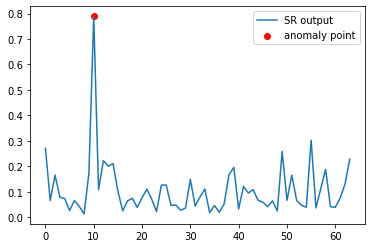

picture   46


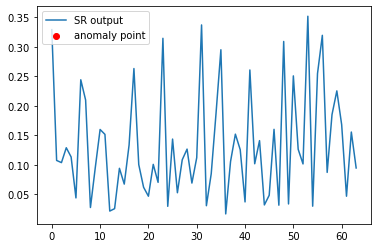

picture   47


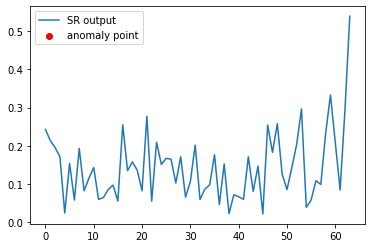

picture   48


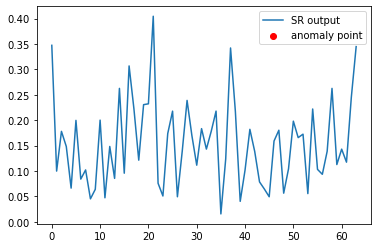

picture   49


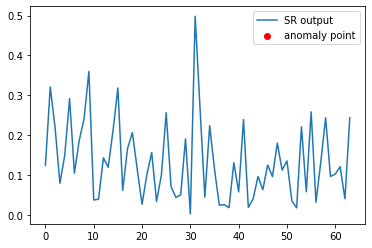

picture   50


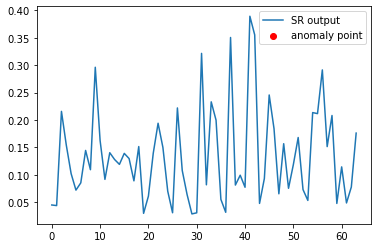

picture   51


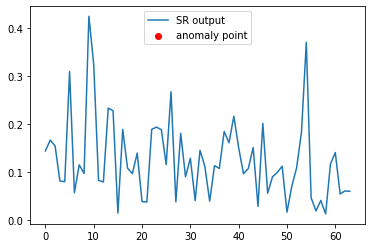

picture   52


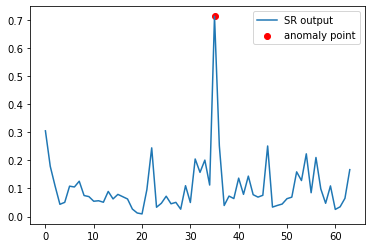

picture   53


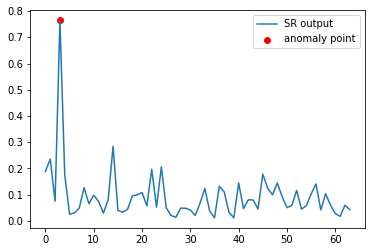

picture   54


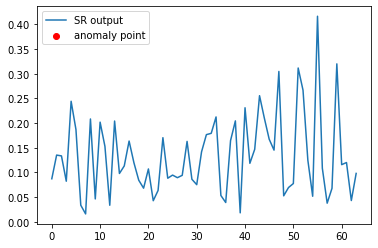

picture   55


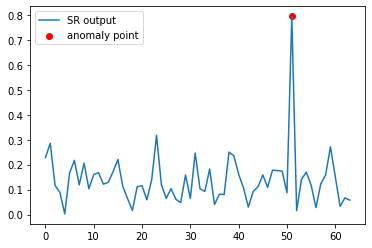

picture   56


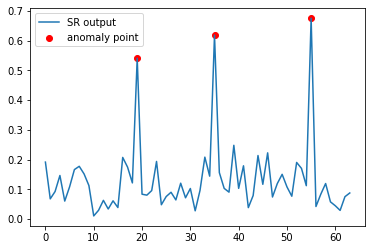

picture   57


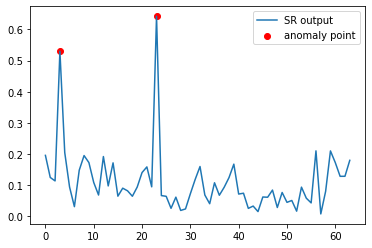

picture   58


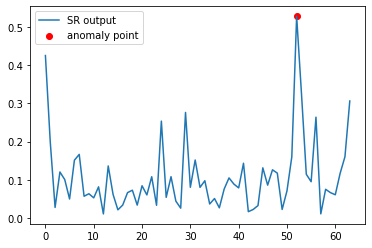

picture   59


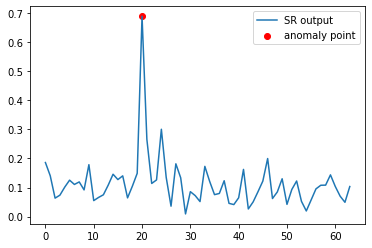

picture   60


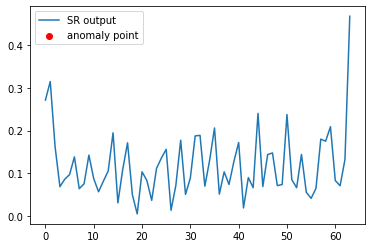

picture   61


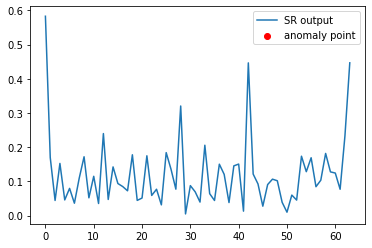

picture   62


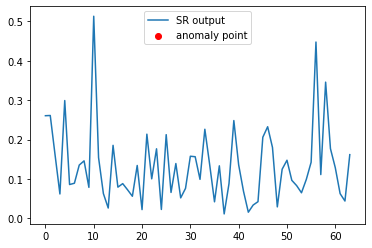

picture   63


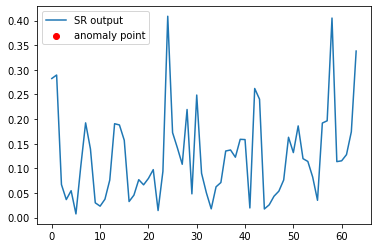

picture   64


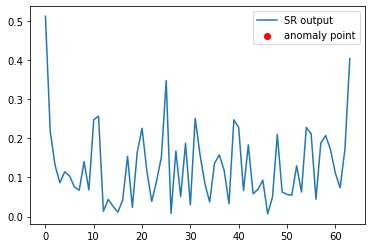

picture   65


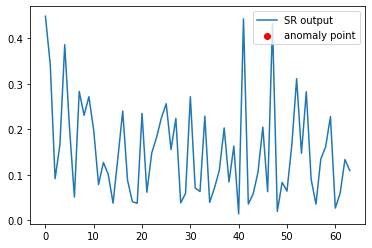

picture   66


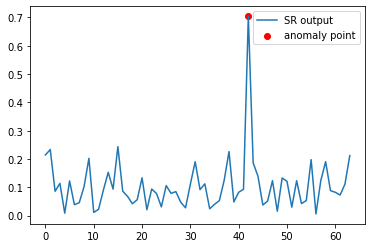

picture   67


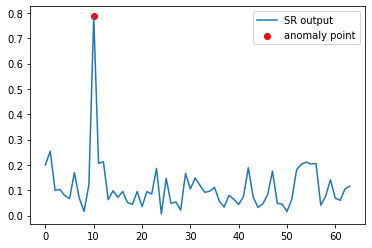

picture   68


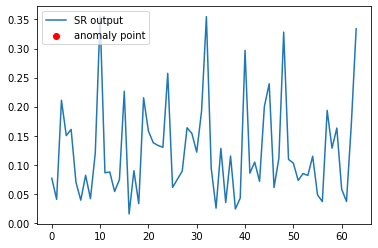

picture   69


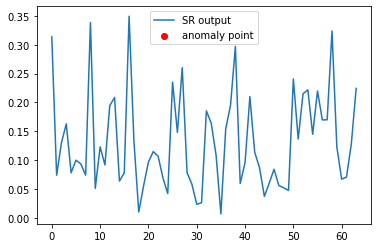

picture   70


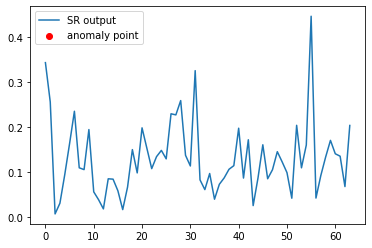

picture   71


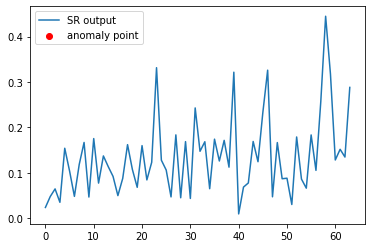

picture   72


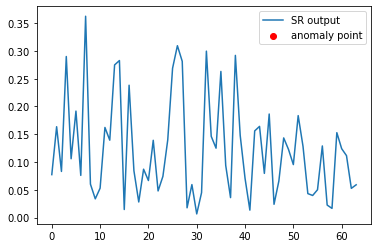

picture   73


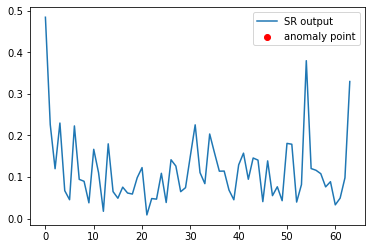

picture   74


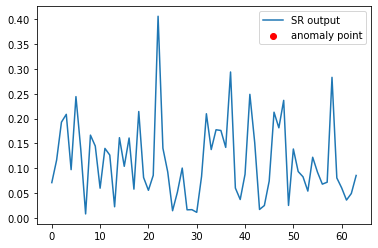

picture   75


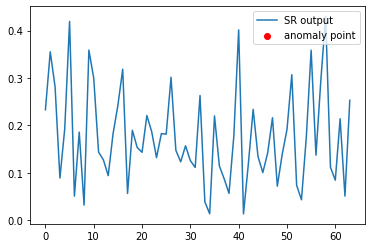

picture   76


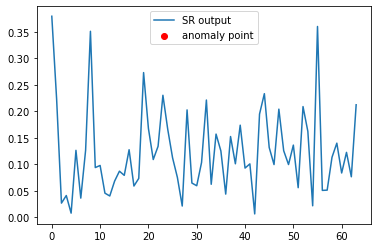

picture   77


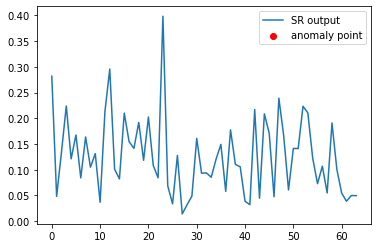

picture   78


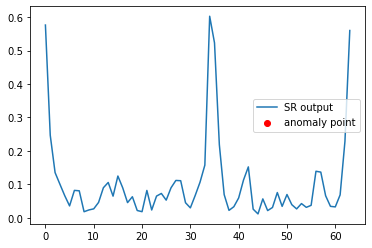

picture   79


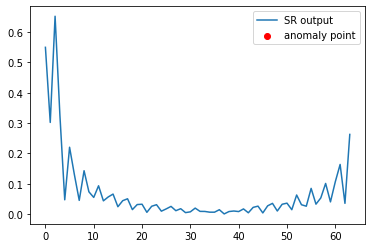

picture   80


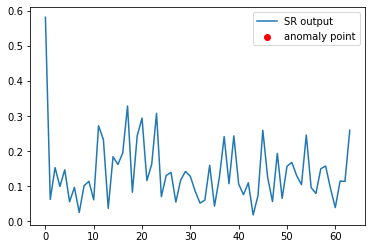

picture   81


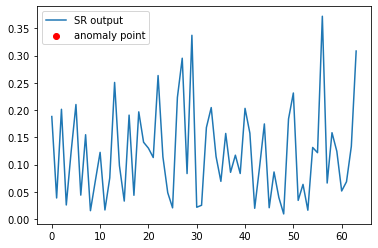

picture   82


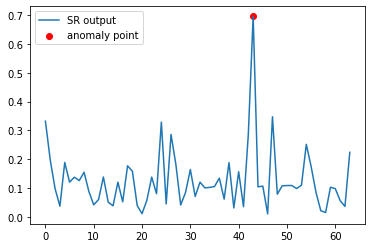

picture   83


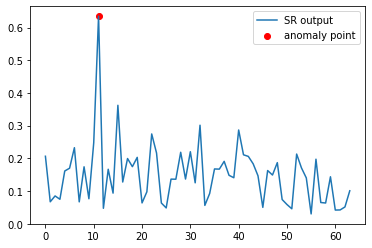

picture   84


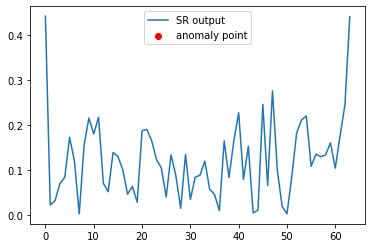

picture   85


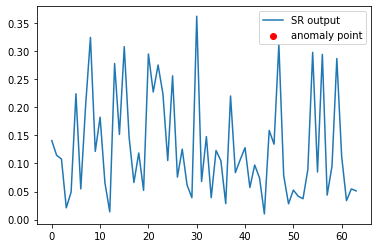

picture   86


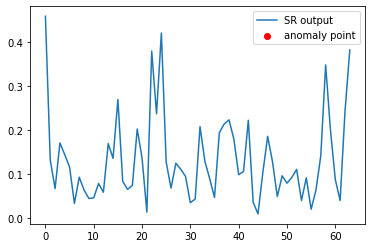

picture   87


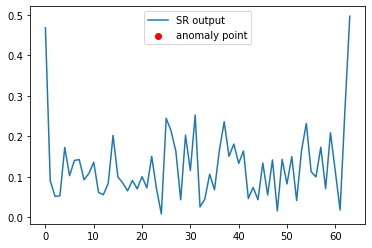

picture   88


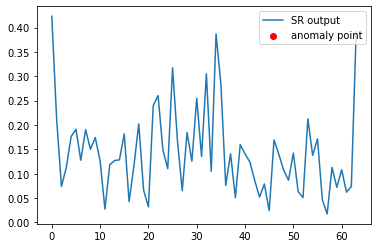

picture   89


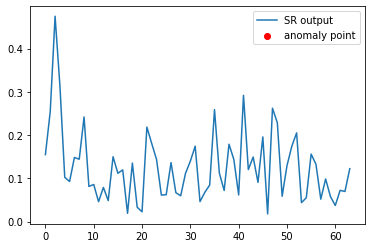

picture   90


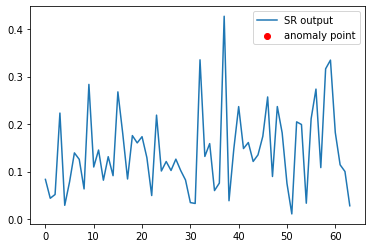

picture   91


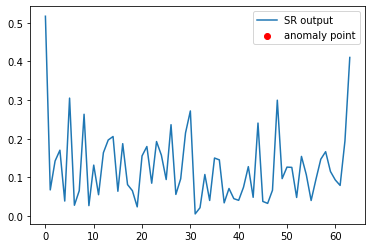

picture   92


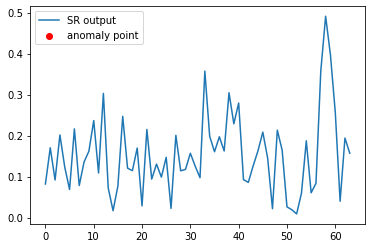

picture   93


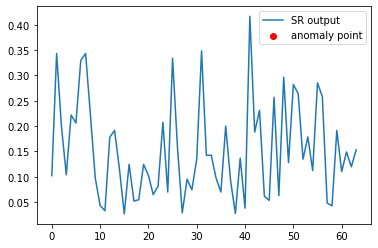

picture   94


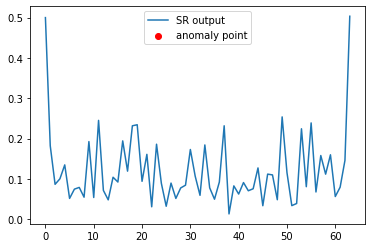

picture   95


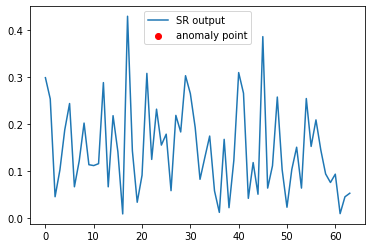

picture   96


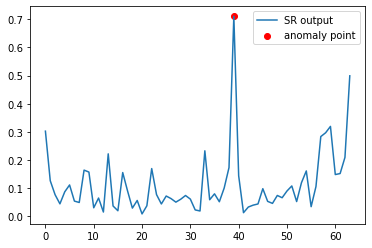

picture   97


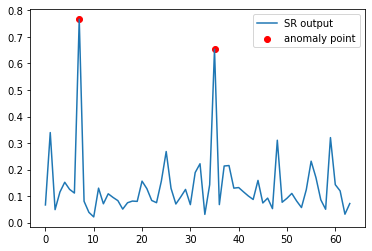

picture   98


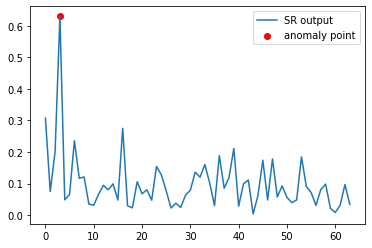

picture   99


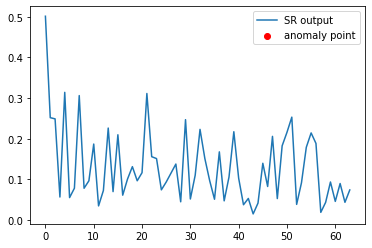

In [39]:
for i in range(100):
    print('picture  ', i)
    plt.plot(SR_output[i], label='SR output')
    index_changes = np.where(test_label[i] == 1)
    plt.scatter(index_changes, SR_output[i][index_changes], c='red', label="anomaly point")
    plt.legend()
    plt.show()

picture   0


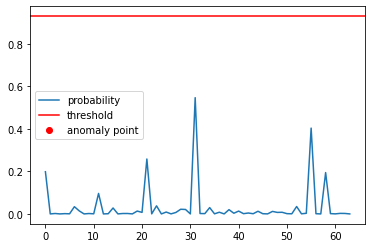

picture   1


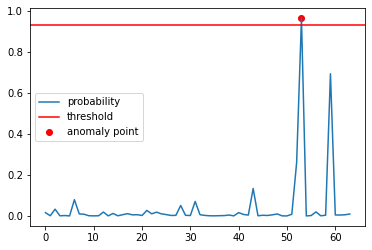

picture   2


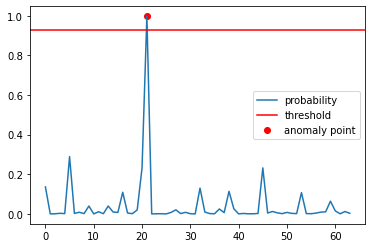

picture   3


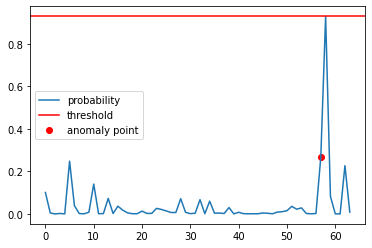

picture   4


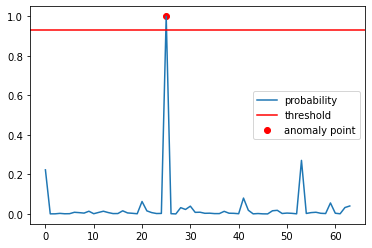

picture   5


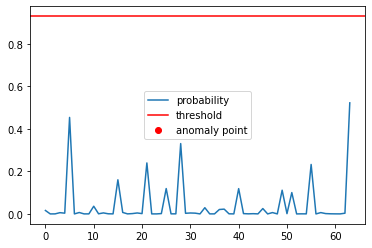

picture   6


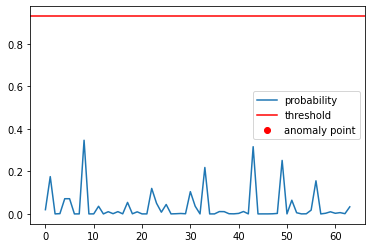

picture   7


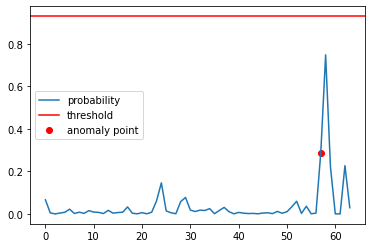

picture   8


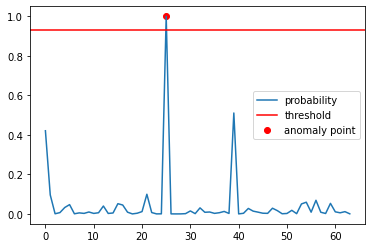

picture   9


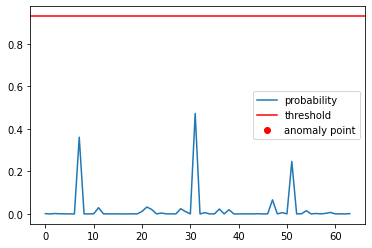

picture   10


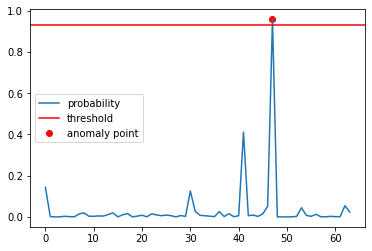

picture   11


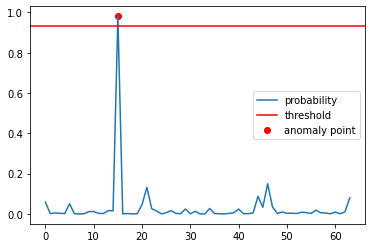

picture   12


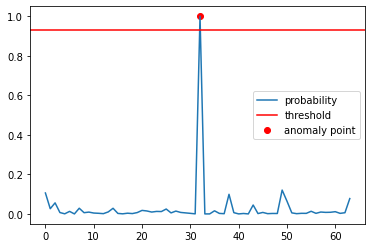

picture   13


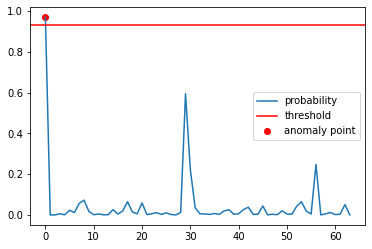

picture   14


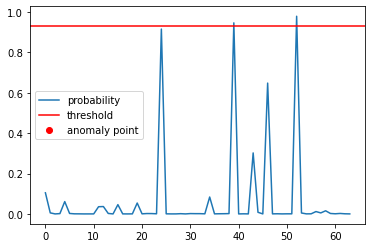

picture   15


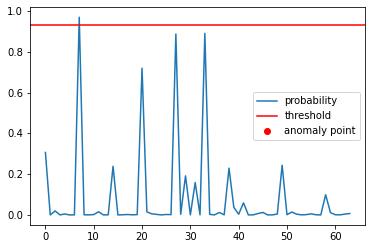

picture   16


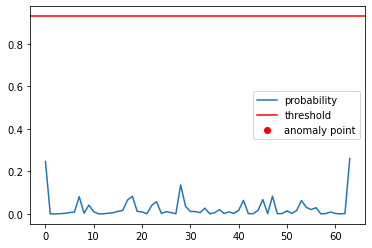

picture   17


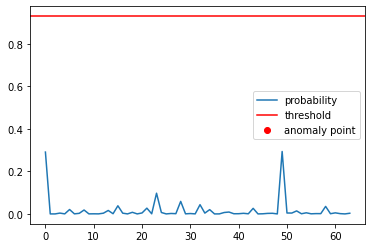

picture   18


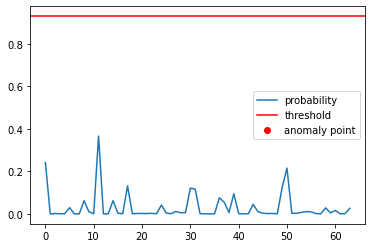

picture   19


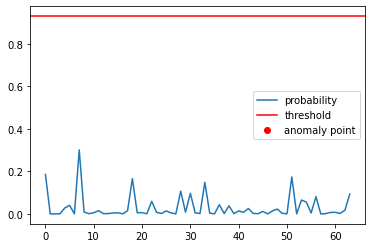

picture   20


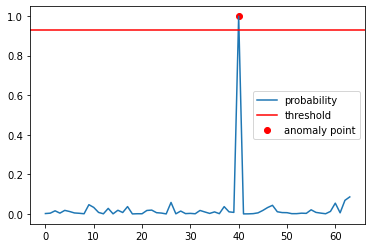

picture   21


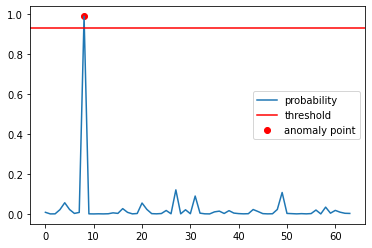

picture   22


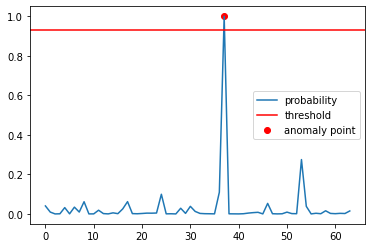

picture   23


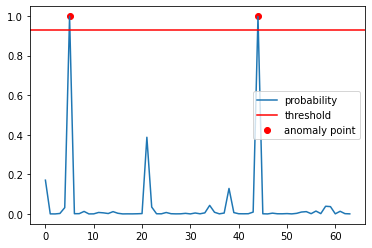

picture   24


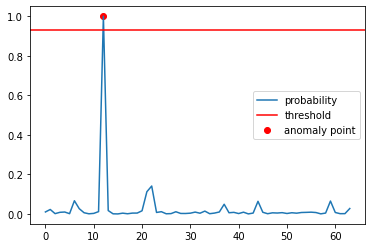

picture   25


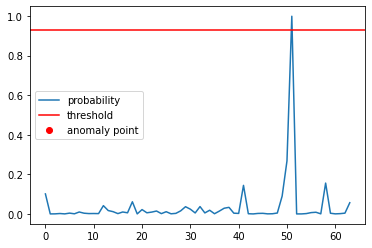

picture   26


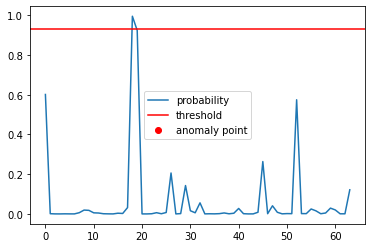

picture   27


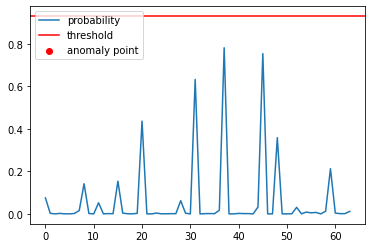

picture   28


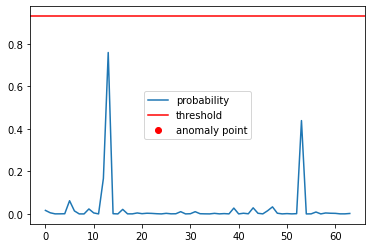

picture   29


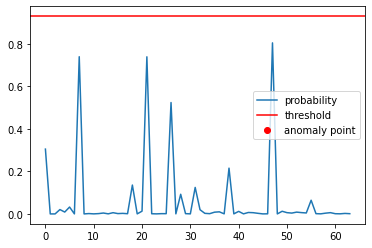

picture   30


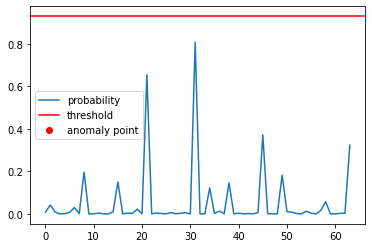

picture   31


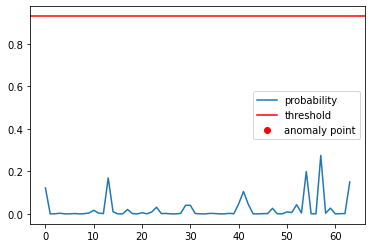

picture   32


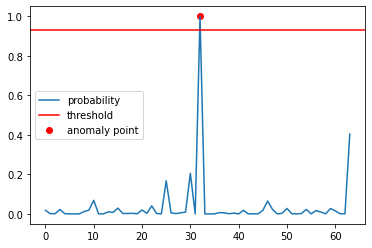

picture   33


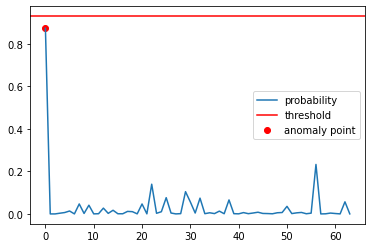

picture   34


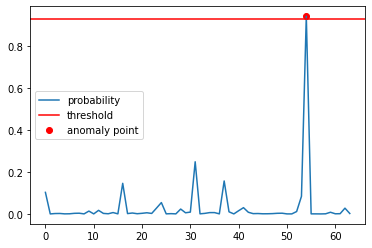

picture   35


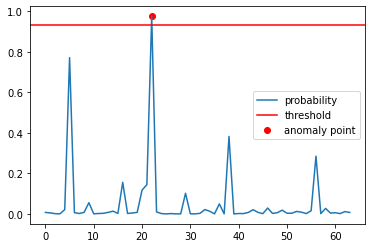

picture   36


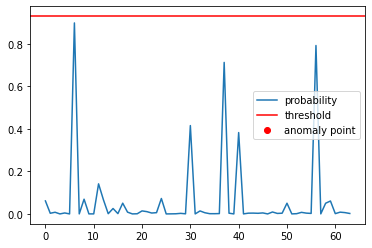

picture   37


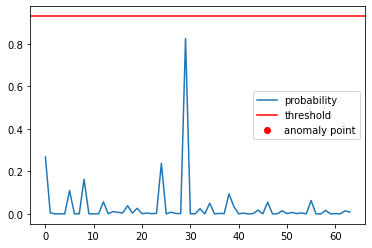

picture   38


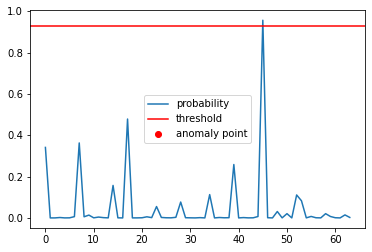

picture   39


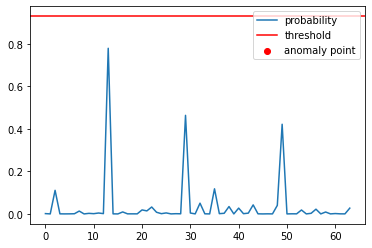

picture   40


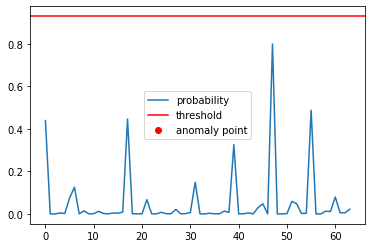

picture   41


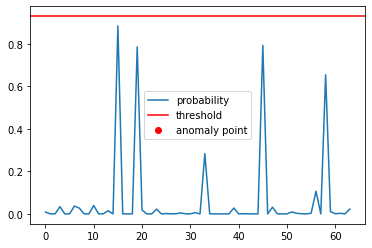

picture   42


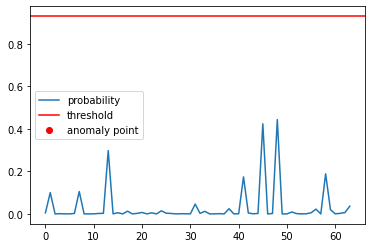

picture   43


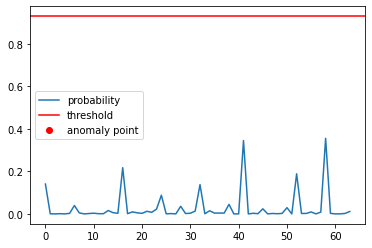

picture   44


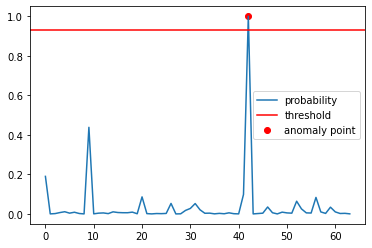

picture   45


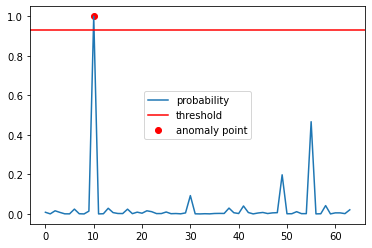

picture   46


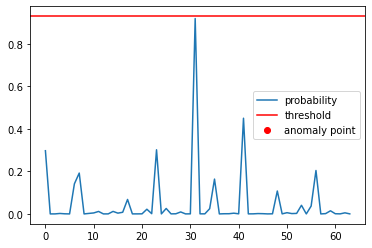

picture   47


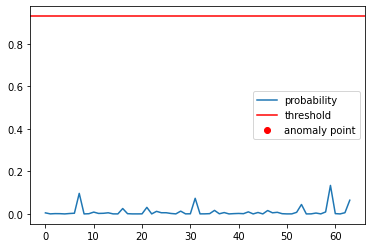

picture   48


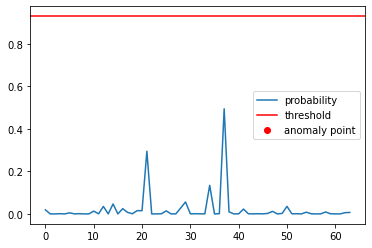

picture   49


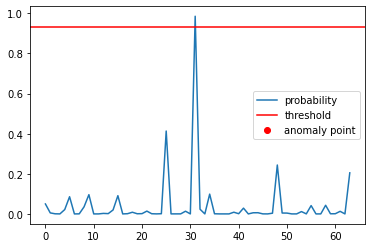

picture   50


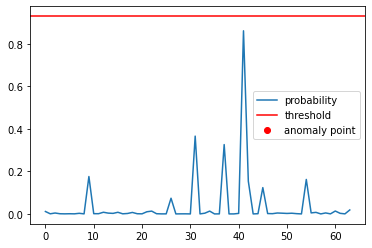

picture   51


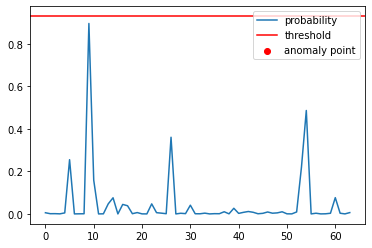

picture   52


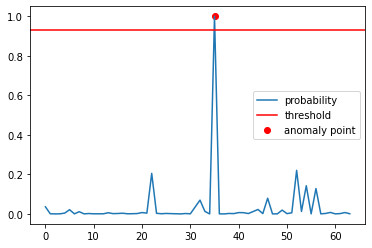

picture   53


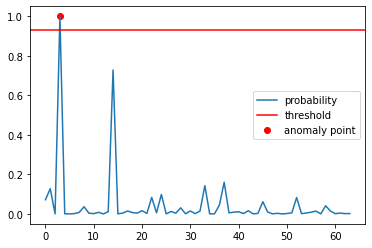

picture   54


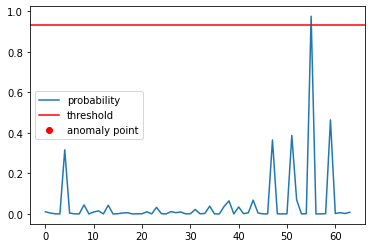

picture   55


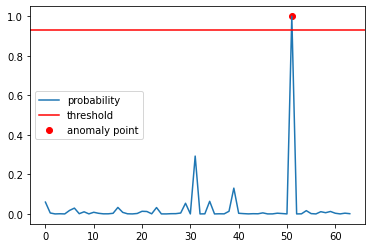

picture   56


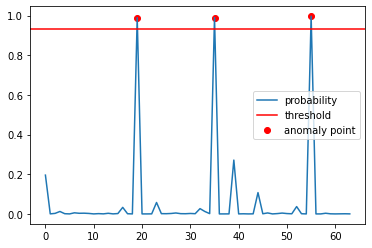

picture   57


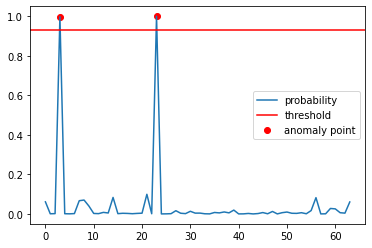

picture   58


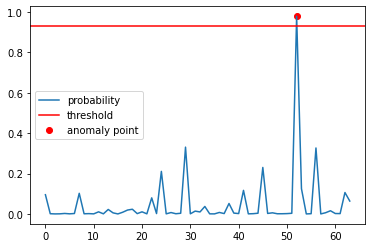

picture   59


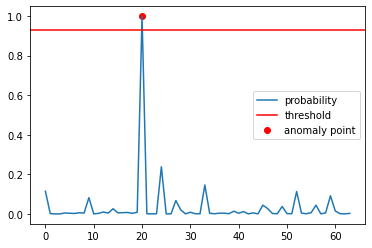

picture   60


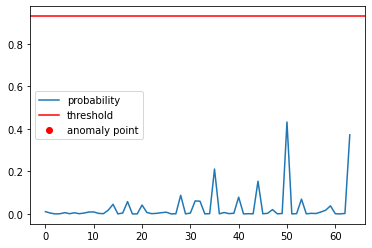

picture   61


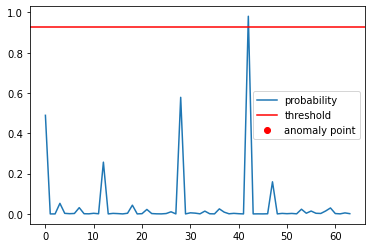

picture   62


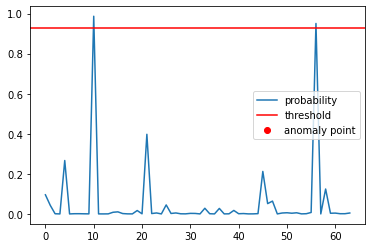

picture   63


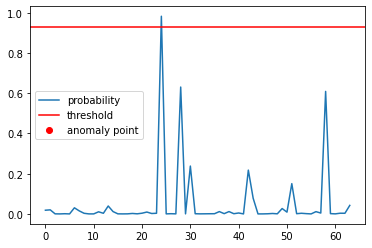

picture   64


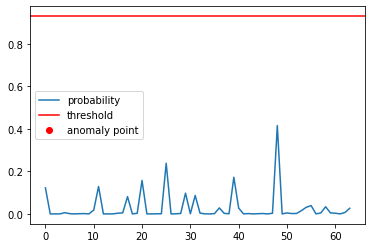

picture   65


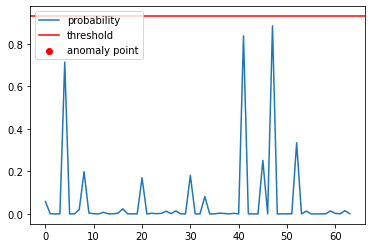

picture   66


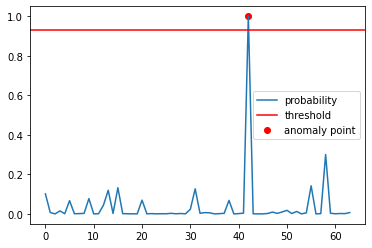

picture   67


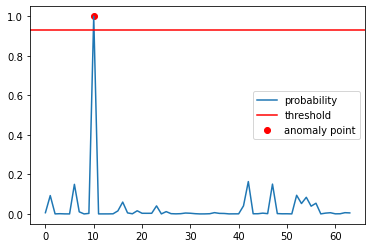

picture   68


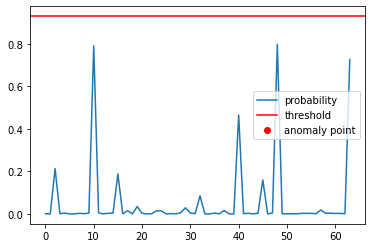

picture   69


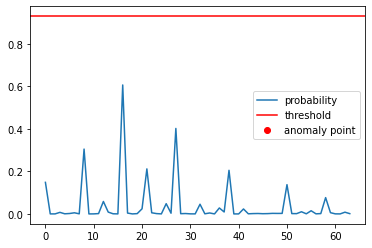

picture   70


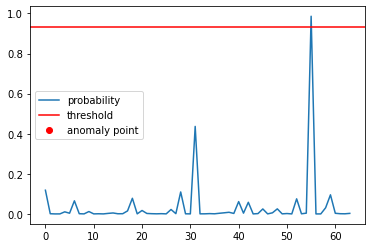

picture   71


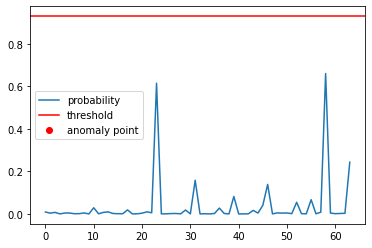

picture   72


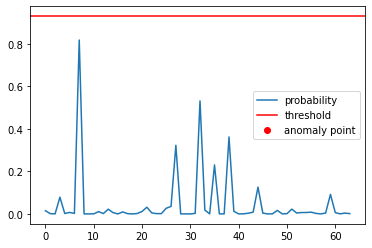

picture   73


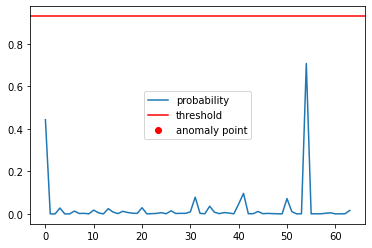

picture   74


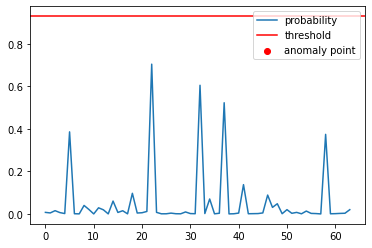

picture   75


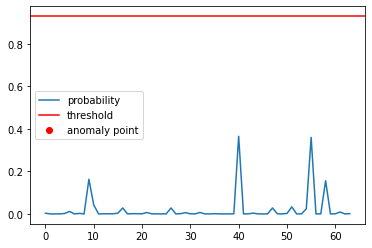

picture   76


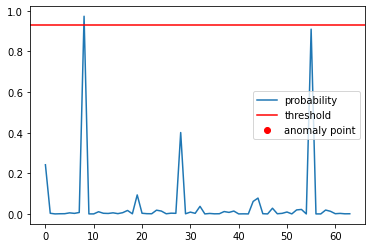

picture   77


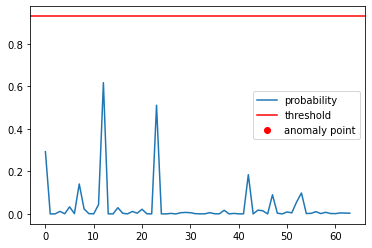

picture   78


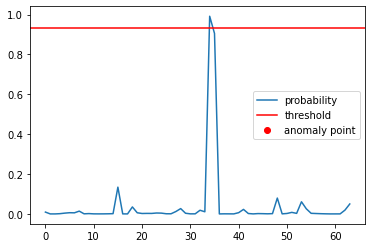

picture   79


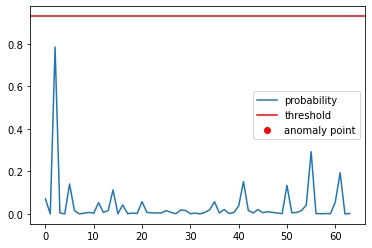

picture   80


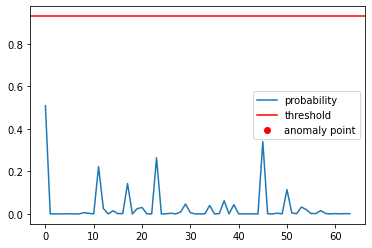

picture   81


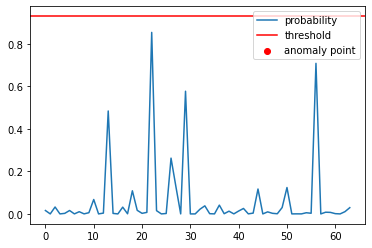

picture   82


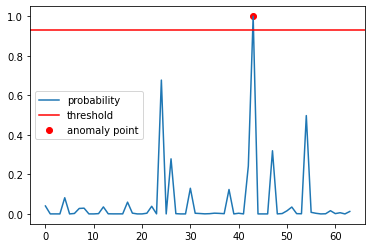

picture   83


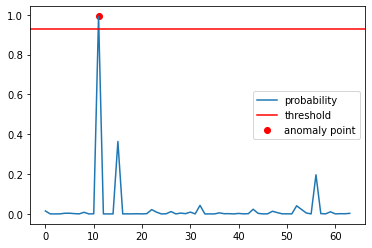

picture   84


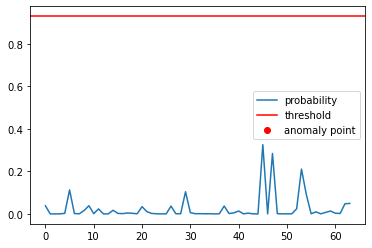

picture   85


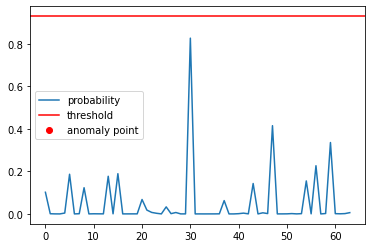

picture   86


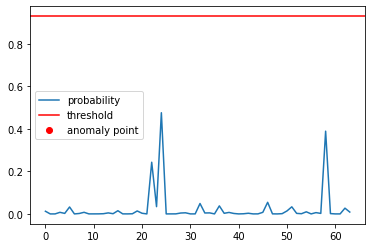

picture   87


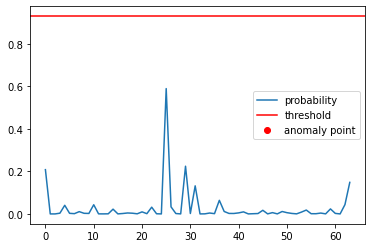

picture   88


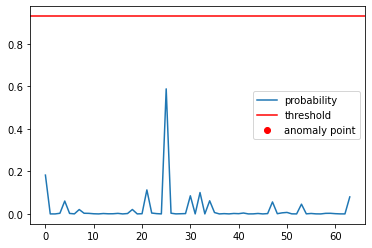

picture   89


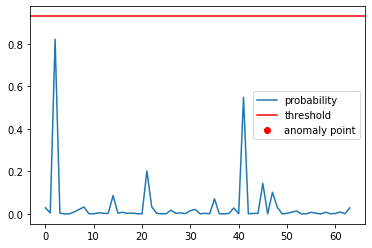

picture   90


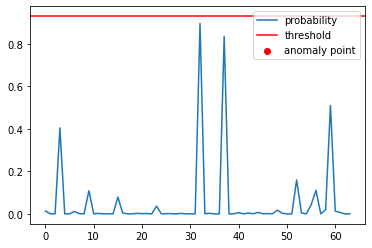

picture   91


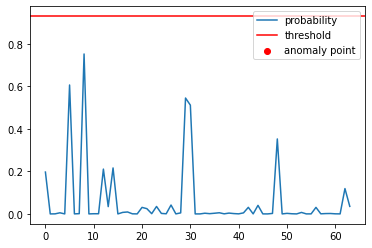

picture   92


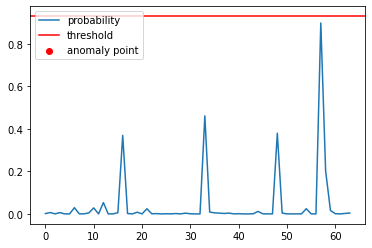

picture   93


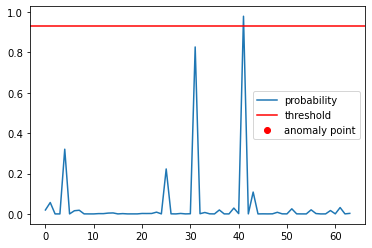

picture   94


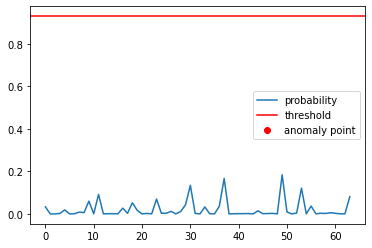

picture   95


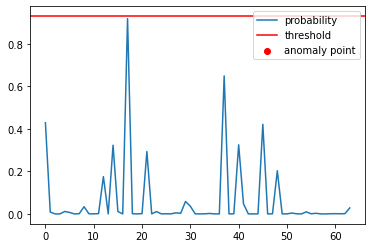

picture   96


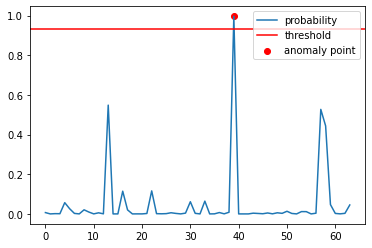

picture   97


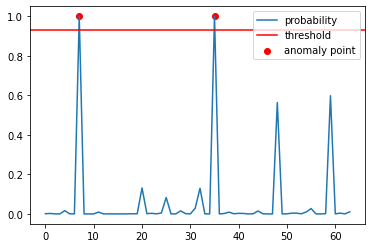

picture   98


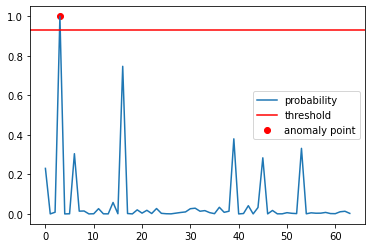

picture   99


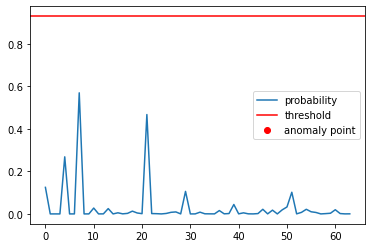

In [46]:
threshold = 0.93
for i in range(100):
    print('picture  ', i)
    plt.plot(cnnout[i], label="probability")
    index_changes = np.where(test_label[i] == 1)
    plt.axhline(y=threshold, c='red', label="threshold")
    plt.scatter(index_changes, cnnout[i][index_changes], c='red', label="anomaly point")
    plt.legend()
    plt.show()

## plot result

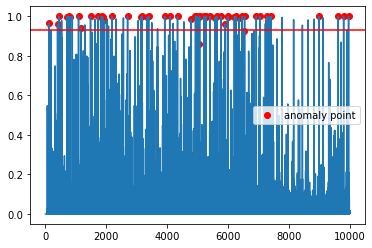

In [41]:
start = 0
end = 10000
threshold = 0.93
f = np.array(savedscore)[0][1][start:end]
plt.plot(f)
plt.axhline(y=threshold, c='red')
index_changes = np.where(np.array(savedscore)[0][0][start:end] == 1)[0]
plt.scatter(index_changes, f[index_changes], c='red', label="anomaly point")
plt.legend()
plt.show()

In [42]:
TN / (FP + TN)

0.8971207421650222

In [43]:
'''threshold = np.percentile(np.array(savedscore)[0][1][np.array(savedscore)[0][0]==1], 0.1*100)
for (flabel, cnnscores, ftimestamp) in savedscore:
    pre = [1 if item > threshold else 0 for item in cnnscores]
    newresults.append([ftimestamp, flabel, pre])

total_fscore, pre, rec, TP, FP, TN, FN = evaluate_for_all_series(newresults, delay, prt=True)
print('best overall threshold :', threshold, 'best F1 score :', total_fscore)
print('best precision', pre)
print('best recall', rec)
print('TP: {:} FP: {:} TN: {:} FN: {:}'.format(TP, FP, TN, FN))'''

"threshold = np.percentile(np.array(savedscore)[0][1][np.array(savedscore)[0][0]==1], 0.1*100)\nfor (flabel, cnnscores, ftimestamp) in savedscore:\n    pre = [1 if item > threshold else 0 for item in cnnscores]\n    newresults.append([ftimestamp, flabel, pre])\n\ntotal_fscore, pre, rec, TP, FP, TN, FN = evaluate_for_all_series(newresults, delay, prt=True)\nprint('best overall threshold :', threshold, 'best F1 score :', total_fscore)\nprint('best precision', pre)\nprint('best recall', rec)\nprint('TP: {:} FP: {:} TN: {:} FN: {:}'.format(TP, FP, TN, FN))"

In [44]:
best = 0.
bestthre = 0.
print('delay :', delay)

for i in range(0, 99, 2):  # 考慮不同的 threshold
    newresults = []
    threshold = 0.01 + i * 0.01
    for (flabel, cnnscores, ftimestamp) in savedscore:
        pre = [1 if item > threshold else 0 for item in cnnscores]
        newresults.append([ftimestamp, flabel, pre])
        
    total_fscore, pre, rec, TP, FP, TN, FN = evaluate_for_all_series(newresults, delay, prt=False)
    
    if total_fscore > best:
        best = total_fscore
        best_pre = pre
        best_rec = rec
        bestthre = threshold
        print('threshold', threshold)
        #print('best_pre', best_pre)
        print('F1 best', best)
        print('TP: {:} FP: {:} TN: {:} FN: {:}'.format(TP, FP, TN, FN))
        print()
        
threshold = bestthre
print('best overall threshold :', threshold, 'best F1 score :', best)
print('best precision', best_pre)
print('best recall', best_rec)

delay : 3
threshold 0.01
F1 best 0.03349699444775846
TP: 1460 FP: 84233 TN: 200771 FN: 19

threshold 0.03
F1 best 0.05940230260471952
TP: 1455 FP: 46054 TN: 238950 FN: 24

threshold 0.05
F1 best 0.08011976379917383
TP: 1445 FP: 33147 TN: 251857 FN: 34

threshold 0.06999999999999999
F1 best 0.09819262701151389
TP: 1437 FP: 26353 TN: 258651 FN: 42

threshold 0.09
F1 best 0.11475278467825949
TP: 1432 FP: 22047 TN: 262957 FN: 47

threshold 0.11
F1 best 0.13079394217530974
TP: 1425 FP: 18886 TN: 266118 FN: 54

threshold 0.13
F1 best 0.14537084398976985
TP: 1421 FP: 16650 TN: 268354 FN: 58

threshold 0.15000000000000002
F1 best 0.15948712180857047
TP: 1418 FP: 14885 TN: 270119 FN: 61

threshold 0.17
F1 best 0.17242011364330667
TP: 1411 FP: 13477 TN: 271527 FN: 68

threshold 0.19
F1 best 0.18479332325688377
TP: 1406 FP: 12332 TN: 272672 FN: 73

threshold 0.21000000000000002
F1 best 0.19842898591748637
TP: 1402 FP: 11250 TN: 273754 FN: 77

threshold 0.23
F1 best 0.2109469240048251
TP: 1399 FP: